# Global plot style

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import os
import glob

# Set the color cycle to use colors from the 'magma' colormap
def set_cycle(num_colors = 10, start=0):
    colors = plt.cm.magma(np.linspace(0, 1, num_colors)[start:])
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

set_cycle()

# The hybrid grid

yt : [WARNING  ] 2024-04-27 17:17:53,796 Cannot determine code units ==> Use units_override to specify the units
yt : [WARNING  ] 2024-04-27 17:17:53,801 Assuming   length unit = 1.000000 cm
yt : [WARNING  ] 2024-04-27 17:17:53,810 Assuming     time unit = 1.000000 s
yt : [WARNING  ] 2024-04-27 17:17:53,819 Assuming     mass unit = 1.000000 g
yt : [WARNING  ] 2024-04-27 17:17:53,825 Assuming magnetic unit = 3.544908 gauss
yt : [INFO     ] 2024-04-27 17:17:53,944 Parameters: current_time              = 0.008
yt : [INFO     ] 2024-04-27 17:17:53,945 Parameters: domain_dimensions         = [64 64 16]
yt : [INFO     ] 2024-04-27 17:17:53,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-27 17:17:53,949 Parameters: domain_right_edge         = [1.   1.   0.25]
yt : [INFO     ] 2024-04-27 17:17:53,951 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-27 17:17:55,263 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-04-27 17:17:55,266 ylim = 0.000000

(800, 800, 4)


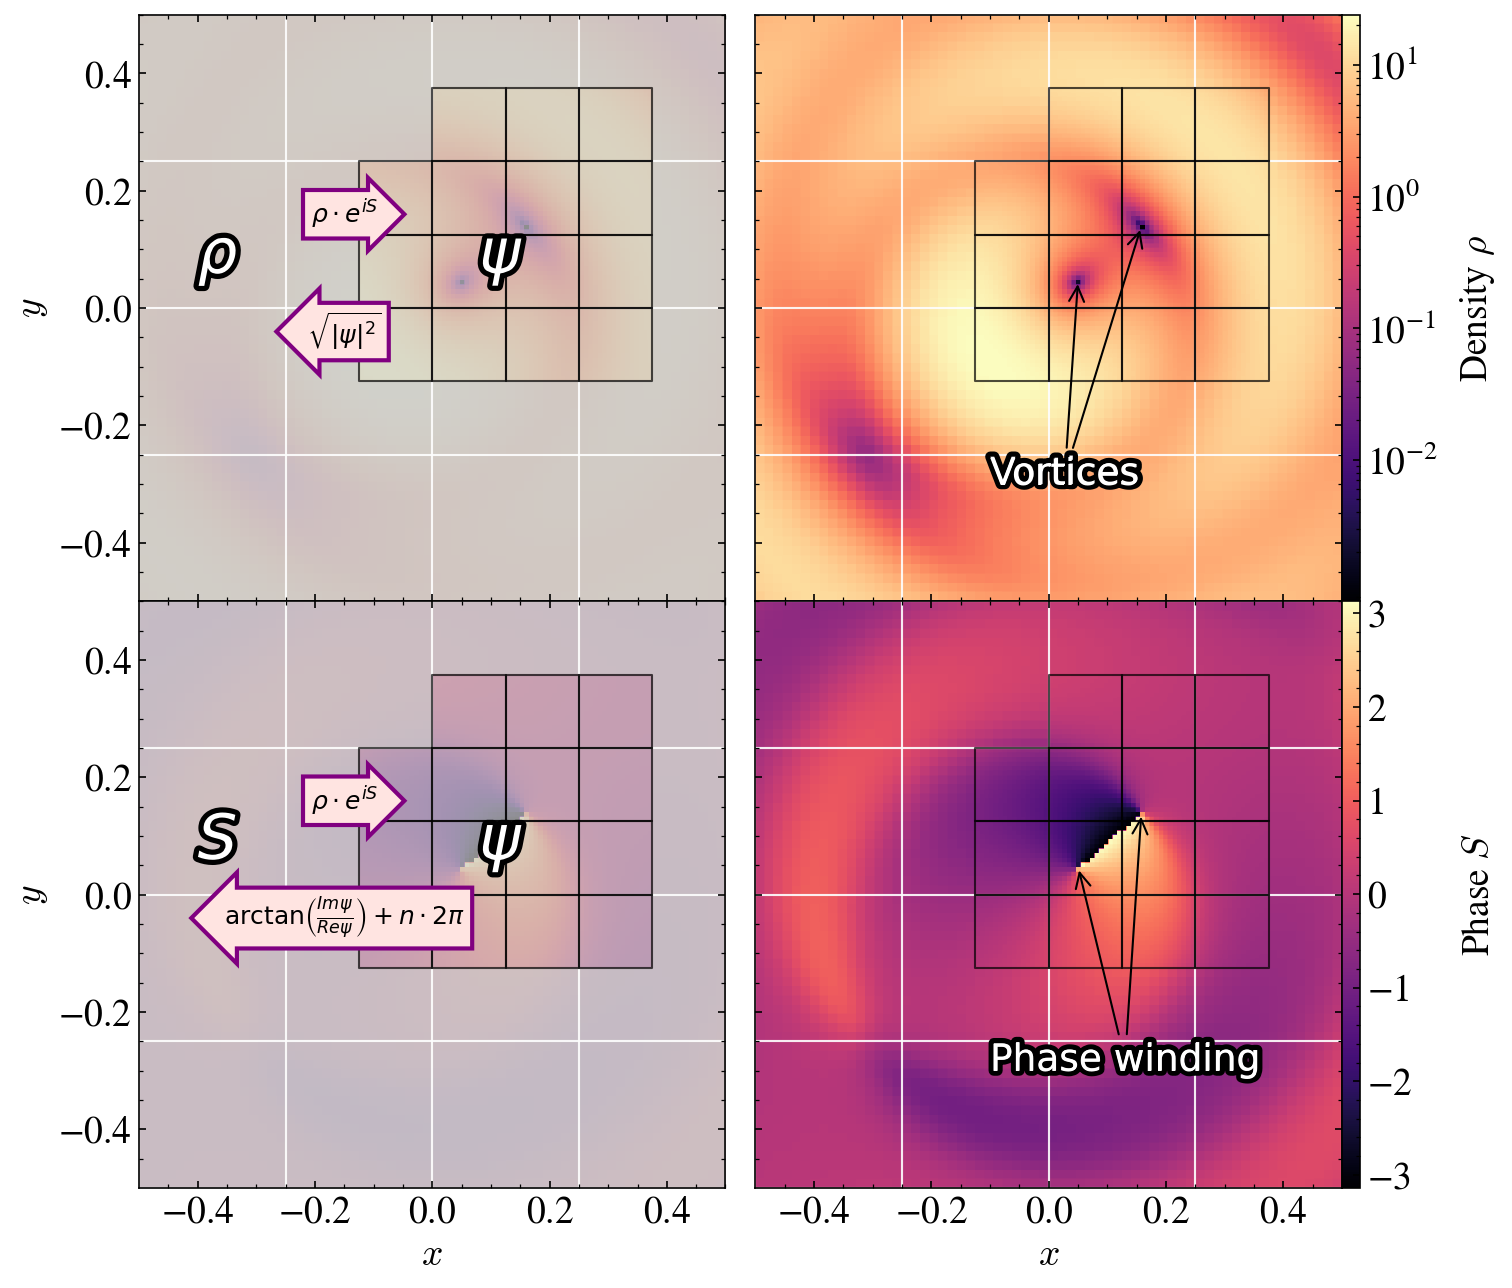

In [8]:
from __future__ import print_function, division, absolute_import

import argparse
import sys
import yt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import AxesGrid

import matplotlib.patheffects as PathEffects

colormap = 'magma'  # Define the colormap for the plots
dpi = 150  # Define the DPI (dots per inch) for the saved plots

# Create a series of datasets based on data files with indices in the specified range
dataset = yt.load("results/Data_000001")

current_axis = "z"

# Create a new figure for the current slice
fig = plt.figure(dpi=dpi, figsize=(24, 12))

# Create a grid of axes for multiple plots
grid = AxesGrid(
    fig,
    (0.075, 0.075, 0.85, 0.85),
    nrows_ncols=(2, 2),
    axes_pad=(0.2, 0.0),
    label_mode="L",
    share_all=True,
    cbar_location="right",
    cbar_mode="edge",
    direction="row",
    cbar_size="3%",
    cbar_pad="0%",
)

# Define the fields to plot
fields_to_plot = [
    ("gas", "density"),
    ("gamer", "Phase"),
]

# Create a slice plot for the current dataset and field
slice_plot = yt.SlicePlot(dataset, current_axis, fields_to_plot)
slice_plot.set_log(("gamer", "Phase"), False)

slice_plot.annotate_grids(periodic=False)

for field in fields_to_plot:
    slice_plot.set_cmap(field, colormap)

# For each plotted field, associate it with the corresponding AxesGrid axes
for i, field in enumerate(fields_to_plot):
    plot = slice_plot.plots[field]
    plot.figure = fig
    plot.axes = grid[2 * i].axes
    plot.cax = grid.cbar_axes[i]

# Create a second slice plot for comparison
slice_plot_2 = yt.SlicePlot(dataset, current_axis, fields_to_plot)
slice_plot_2.set_log(("gamer", "Phase"), False)
slice_plot_2.annotate_grids(periodic=False)

for field in fields_to_plot:
    slice_plot_2.set_cmap(field, colormap)

# Associate the second slice plot with the AxesGrid axes
for i, field in enumerate(fields_to_plot):
    plot = slice_plot_2.plots[field]
    plot.figure = fig
    plot.axes = grid[2 * i + 1].axes

# Redraw the plot on the AxesGrid axes
slice_plot._setup_plots()
slice_plot_2._setup_plots()

# Assuming 'z' axis slices, the size of the plot, and other parameters
axis = 'z'
width = 1#dataset.domain_width.min().value  # Adjust based on your dataset

# Create Fixed Resolution Buffers (FRBs) for density and AMR level visualization
res = [800, 800]  # Adjust resolution based on your needs

# Extracting AMR level data
# Note: Modify this part according to how you can get AMR level data from your dataset
amr_data = slice_plot.data_source.to_frb(width, res, height=width)

# Visualizing AMR levels
# Assume `amr_data["index", "grid_level"]` provides the AMR level data, you may need to adjust this
amr_levels = amr_data["index", "grid_level"]
level_0_mask = amr_levels == 0
level_1_mask = amr_levels == 1

# Initialize an RGBA image with full transparency (alpha = 0)
amr_image_rgba = np.zeros((res[0], res[1], 4), dtype=np.float32)  # Last dimension for RGBA

# Set colors with alpha for AMR levels
# Here, 0.5 is used as an example alpha value for both levels, adjust according to your preferences
light_grey_rgba = [0.8, 0.8, 0.8, 0.9]  # Light grey with alpha for level 0
dark_grey_rgba  = [0.8, 0.8, 0.8, 0.7]  # Dark grey with alpha for level 1

# Apply colors with alpha based on AMR level masks
amr_image_rgba[level_0_mask, :] = light_grey_rgba
amr_image_rgba[np.logical_not(level_0_mask), :] = dark_grey_rgba

print(amr_image_rgba.shape)

# Plotting the RGBA image with alpha
# Using the same extent as before to align with other plots
grid[0].imshow(amr_image_rgba, origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])
grid[2].imshow(amr_image_rgba, origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

dy = 0.06

# Add annotations or other plot elements as needed
txt = grid[0].annotate(r"$\rho$", (-0.4, 0 + dy), fontsize=30, c="w")
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
#grid[0].annotate(r"$\rho$", (-0.4, 0), fontsize=28, c="white")
txt = grid[0].annotate(r"$\psi$", (0.08, 0 + dy), fontsize=30, c="w")
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])

grid[0].text(-0.15, 0.1 + dy, r"$\rho \cdot e^{iS}$",
            ha="center", va="center", rotation=0, size=12,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="mistyrose", ec="purple", lw=2))
grid[0].text(-0.15, -0.1 + dy, r"$\sqrt{|\psi|^2}$",
            ha="center", va="center", rotation=0, size=12,
            bbox=dict(boxstyle="larrow,pad=0.3",
                      fc="mistyrose", ec="purple", lw=2))

txt = grid[2].annotate(r"$S$", (-0.4, 0 + dy), fontsize=30, c="w")
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
txt = grid[2].annotate(r"$\psi$", (0.08, 0 + dy), fontsize=30, c="w")
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
grid[2].text(-0.15, 0.1 + dy, r"$\rho \cdot e^{iS}$",
            ha="center", va="center", rotation=0, size=12,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="mistyrose", ec="purple", lw=2))
grid[2].text(-0.15, -0.1 + dy, r"arctan$\left(\frac{Im{\psi}}{Re{\psi}}\right) + n \cdot 2 \pi$",
            ha="center", va="center", rotation=0, size=12,
            bbox=dict(boxstyle="larrow,pad=0.3",
                      fc="mistyrose", ec="purple", lw=2))


txt = grid[1].annotate("Vortices",
            xy=(0.158, 0.14), xycoords='data',
            xytext=(-0.1, -0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), c="w", fontsize=18)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
grid[1].annotate("Vortices",
            xy=(0.05, 0.048), xycoords='data',
            xytext=(-0.1, -0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), c="w", fontsize=18, alpha=1)


txt = grid[3].annotate("Phase winding",
            xy=(0.158, 0.14), xycoords='data',
            xytext=(-0.1, -0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), c="w", fontsize=18)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
grid[3].annotate("Phase winding",
            xy=(0.05, 0.048), xycoords='data',
            xytext=(-0.1, -0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), c="w", fontsize=18, alpha=1)

grid[0].set_ylabel("$y$")
grid[2].set_ylabel("$y$")
grid[2].set_xlabel("$x$")
grid[3].set_xlabel("$x$")
grid.cbar_axes[0].get_yaxis().labelpad = 10
grid.cbar_axes[0].get_yaxis().set_ticks([1e-2, 1e-1, 1, 1e1])
grid.cbar_axes[0].set_ylabel(r"Density $\rho$", rotation=90)
grid.cbar_axes[1].get_yaxis().labelpad = 24
grid.cbar_axes[1].set_ylabel(r"Phase $S$", rotation=90)
# Get the DumpID from dataset parameters and save the plot
dump_id = dataset.parameters["DumpID"]
plt.savefig("plots/boundary_matching.pdf")

# Close the current figure to release resources
plt.show()
plt.close()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.special import j1

from matplotlib import gridspec

# Function to generate the complex wave function based on the Schrödinger equation
def generate_wave_function(x, y, VorPairLin_kx = 1, VorPairLin_ky = 1, time = 0):
    # Given parameters
    if 0:
        VorPairLin_BgAmp = 1
        VorPairLin_WaveAmp = 1.0
        VorPairLin_Phase0 = 0.0
        VorPairLin_Omega = 0.5  # Simplified for demonstration

        phase = VorPairLin_kx * x - VorPairLin_Omega * time + VorPairLin_Phase0
        amp = VorPairLin_WaveAmp * np.cos(VorPairLin_ky * y)
        Re = VorPairLin_BgAmp + amp * np.cos(phase)
        Im = amp * np.sin(phase)
        return Re + 1j * Im

    else:
        VorPairRot_Omega = 90
        VorPairRot_Phase0 = 0
        VorPairRot_J1Amp = 5
        VorPairRot_BgAmp = 2

        dx = x
        dy = y
        phase = np.arctan2(dy, dx) - VorPairRot_Omega * Time + VorPairRot_Phase0
        R = np.sqrt(dx ** 2 + dy ** 2)
        J1 = VorPairRot_J1Amp * j1(np.sqrt(2.0 * ELBDM_ETA * VorPairRot_Omega) * R)
        Re = VorPairRot_BgAmp - J1 * np.cos(phase)
        Im = -J1 * np.sin(phase)
        return Re + 1j * Im

Time = 0.0  # Example time moment
ELBDM_ETA = 1.0  # Just an example value, adjust according to your setup

N = 512
Nh = 256
# Grid setup
x = np.linspace(-0.5, 0.5, N, endpoint=False)
y = np.linspace(-0.5, 0.5, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wave function computation
psi = generate_wave_function(X, Y)
Re, Im = np.real(psi), np.imag(psi)

# Density calculation
density = Re**2 + Im**2

# Density calculation
density = Re**2 + Im**2
phase   = np.arctan2(Im, Re)


/tmp/ipykernel_119000/3548237559.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


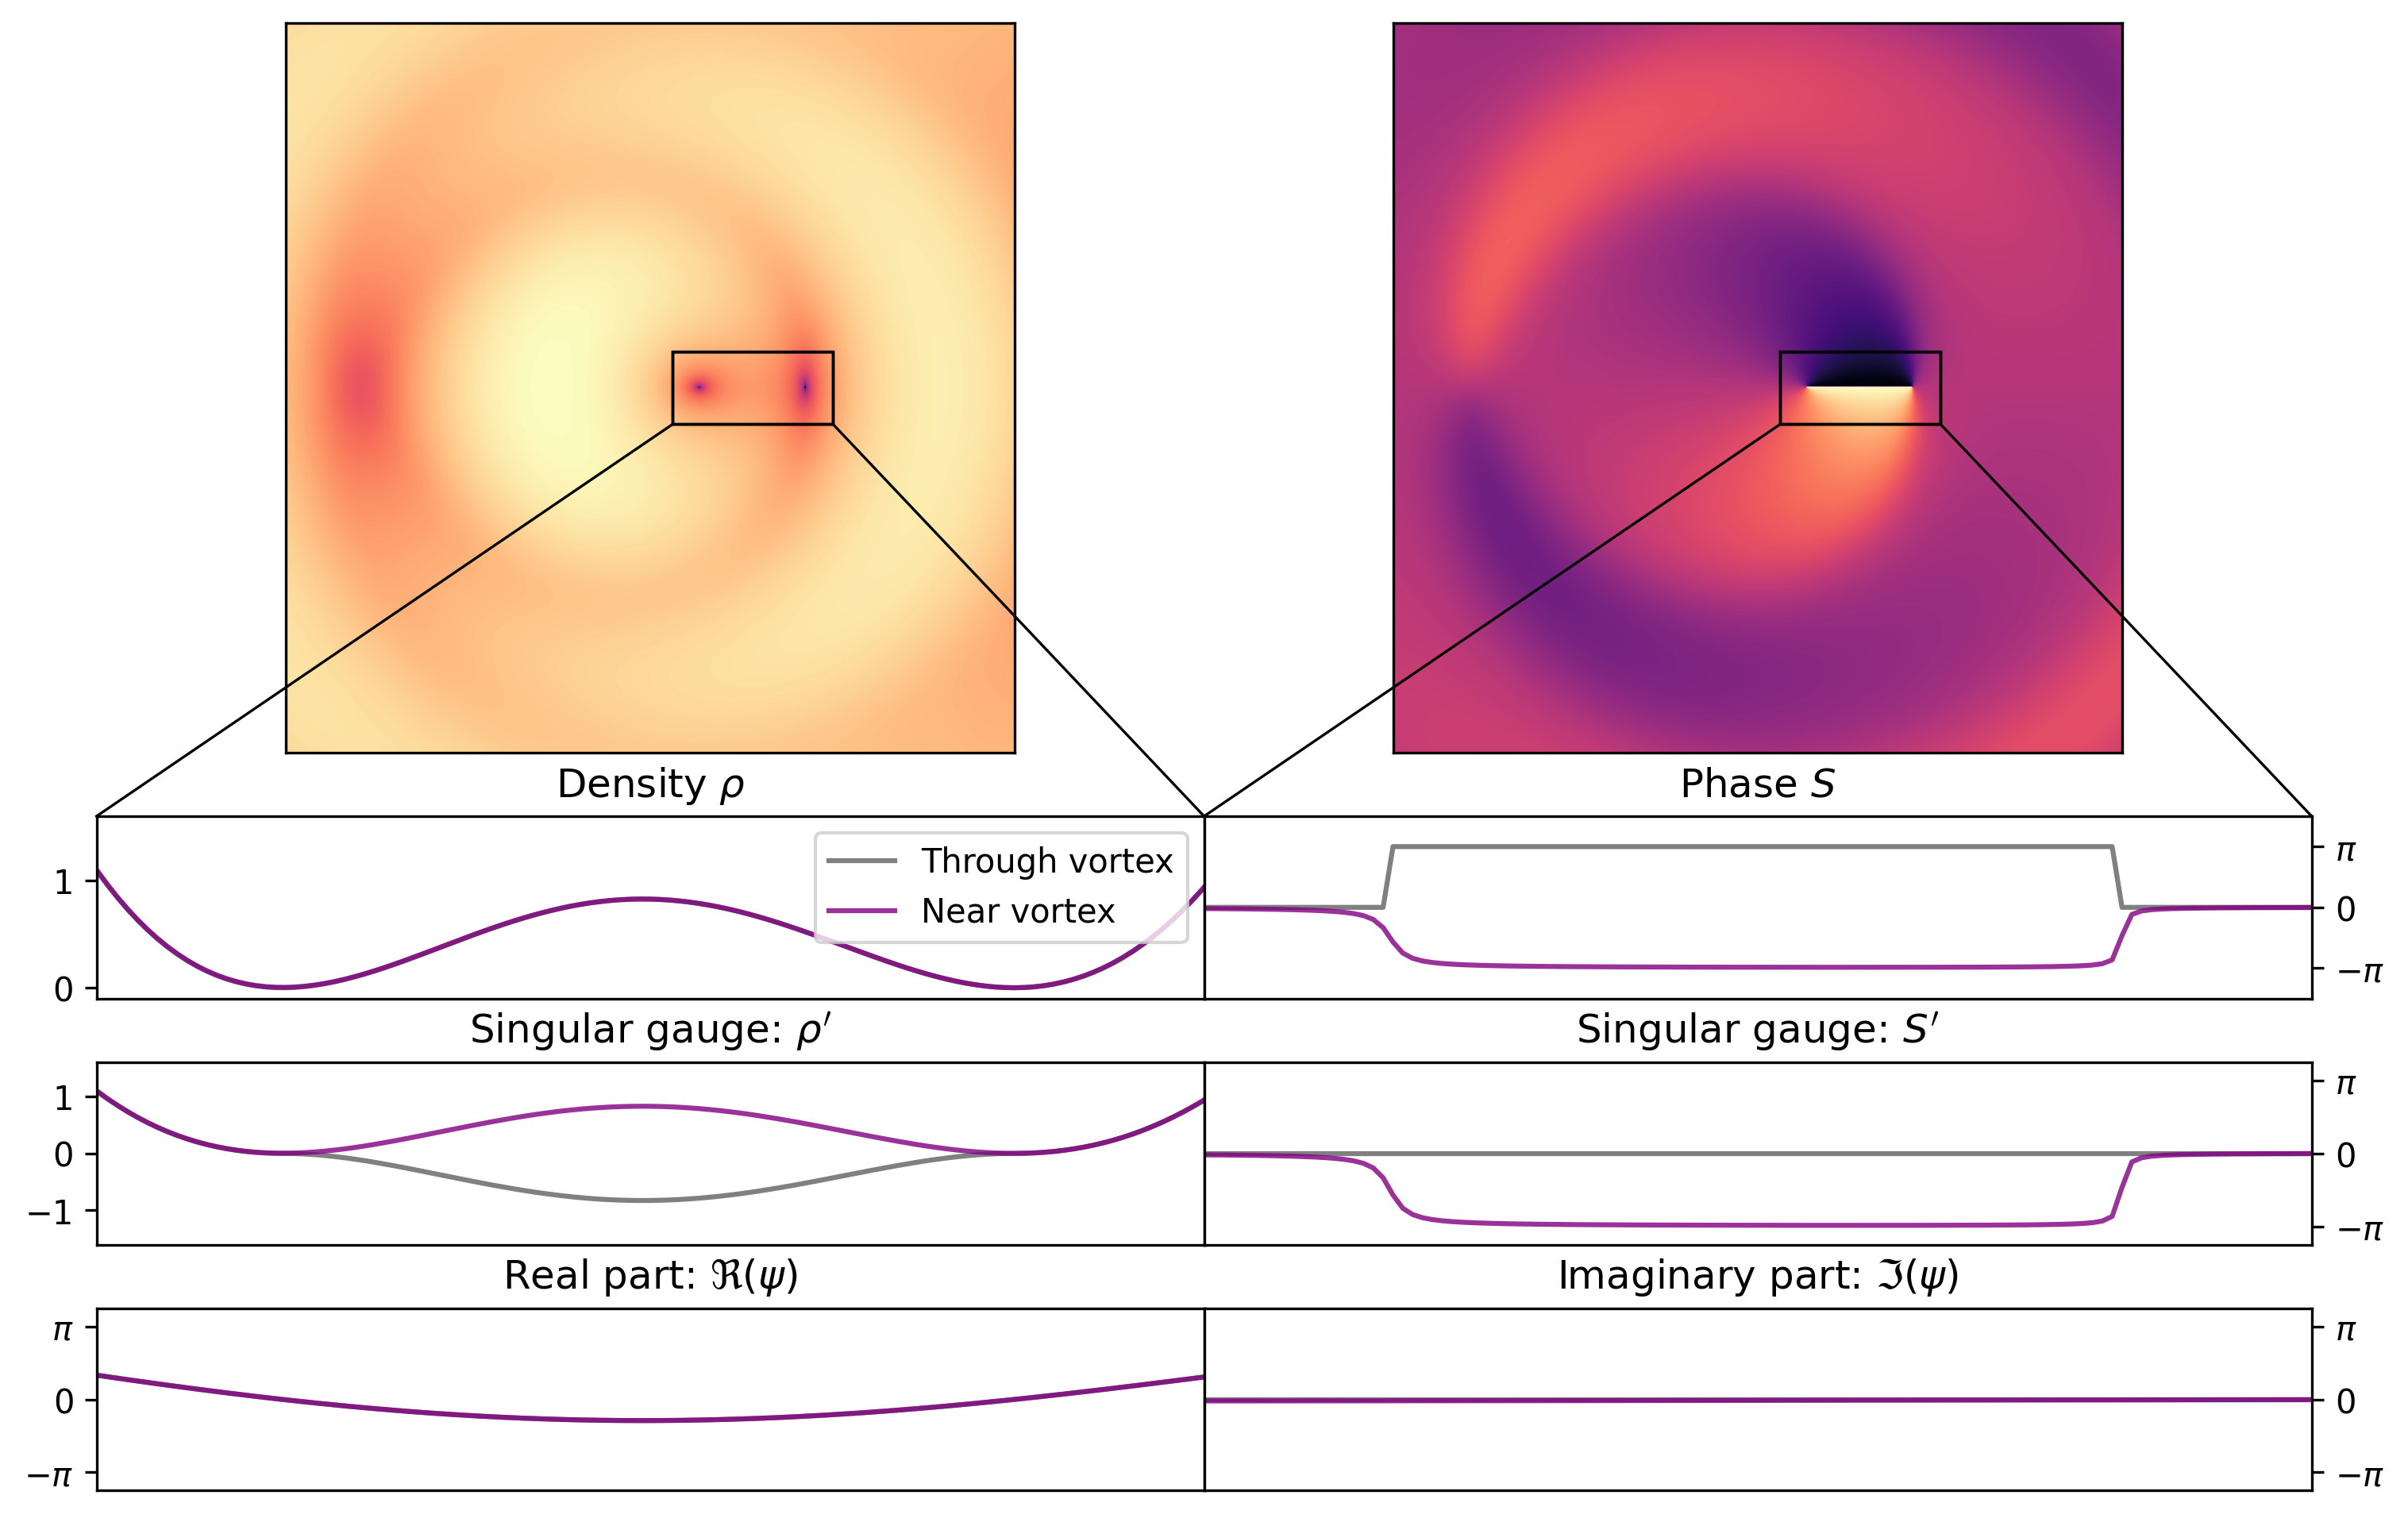

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

extent = (0, 1, 0, 1)

fig = plt.figure(figsize=(12, 8), dpi=300)
gs = gridspec.GridSpec(4, 2, height_ratios=[4, 1, 1, 1], hspace=0.2, wspace=0.0)

# Create the top row for 2D data visualization
data = [density, phase]
axes = []
for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    if i == 0:
        ax.imshow(np.log(data[i]), cmap="magma", extent=extent, origin="lower")
    else:
        ax.imshow(data[i], cmap="magma", extent=extent, origin="lower")
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)

x0 = 0.53
x1 = 0.75
y_index = Nh

# Create the lower rows for 1D data visualization
for i in range(2):
    for j in range(1, 4):
        ax = fig.add_subplot(gs[j, i])

        if j == 1:
            if i == 0:
                ax.set_ylim([-0.1, 1.6])
            elif i == 1:
                ax.set_ylim([-1.5*np.pi, 1.5*np.pi])
                ax.set_yticks([-np.pi, 0, np.pi], [r"$-\pi$", "$0$", r"$\pi$"])

        elif j == 2:
            if i == 0:
                ax.set_ylim([-1.6, 1.6])
            elif i == 1:
                ax.set_ylim([-1.25*np.pi, 1.25*np.pi])
                ax.set_yticks([-np.pi, 0, np.pi], [r"$-\pi$", "$0$", r"$\pi$"])
        elif j == 3:
            if i == 0:
                ax.set_ylim([-1.25*np.pi, 1.25*np.pi])
                ax.set_yticks([-np.pi, 0, np.pi], [r"$-\pi$", "$0$", r"$\pi$"])
            elif i == 1:
                ax.set_ylim([-1.25*np.pi, 1.25*np.pi])
                ax.set_yticks([-np.pi, 0, np.pi], [r"$-\pi$", "$0$", r"$\pi$"])


        for p, y_index in enumerate([Nh, Nh+1]):
            x = np.linspace(0, 1, N)
            r = data[0][y_index, :].copy()
            s = data[1][y_index, :].copy()

            # Singular gauge transformation
            if j == 2:
                for k in range(1, len(s)):
                    if np.abs(s[k] - s[k-1]) > np.pi * 0.9:
                        s[k:] -= np.pi * np.sign(s[k] - s[k-1])
                        r[k:] *= -1
            elif j == 3:
                b = np.sqrt(r)
                r = b * np.cos(s)
                s = b * np.sin(s)


            label = ""
            title = ""

            if j == 1:
                title="Density & Phase"
                if i == 0:
                    label = r"Density $\rho$"
                elif i == 1:
                    label = r"Phase $S$"
            elif j == 2:
                title="Singular gauge"
                if i == 0:
                    label = r"Singular gauge: $\rho'$"
                elif i == 1:
                    label = r"Singular gauge: $S'$"
            elif j == 3:
                title="Wave function"
                if i == 0:
                    label = r"Real part: $\Re(\psi)$"
                elif i == 1:
                    label = r"Imaginary part: $\Im(\psi)$"

            ax.set_title(label)
            if i == 0:
                y = r
            else:
                y = s
                ax.yaxis.set_label_position("right")
                ax.yaxis.tick_right()

            if p == 0:
                # Simulate some 1D data extraction and plotting
                ax.plot(x, y, lw =1.5, color='grey', label = "Through vortex")
            elif p == 1:
                # Simulate some 1D data extraction and plotting
                ax.plot(x, y, lw =1.5, color='purple', alpha = 0.8, label = "Near vortex")
        if i == 0 and j == 1:
            ax.legend()

        #ax.legend(title=title, loc="upper left")
        ax.set_xlim(x0, x1)  # Example limit; adjust as necessary
        ax.set_xticks([])


        # Drawing a rectangle in the top plot to indicate zoom region
        rect = plt.Rectangle((x0, 0.45), x1-x0, 0.1, fill=False, color="k", linewidth=.8)
        axes[i].add_patch(rect)

        if j == 1:
            # Draw lines connecting the rectangle to the inset plots
            trans_fig = fig.transFigure.inverted()
            coordsA = trans_fig.transform(axes[i].transData.transform([0.52, 0.45]))
            coordsB = trans_fig.transform(ax.transAxes.transform([0, 1]))
            line = plt.Line2D((coordsA[0], coordsB[0]), (coordsA[1], coordsB[1]), transform=fig.transFigure, color='k', linewidth=.8)
            fig.lines.append(line)

            coordsA = trans_fig.transform(axes[i].transData.transform([0.665, 0.45]))
            coordsB = trans_fig.transform(ax.transAxes.transform([1, 1]))
            line = plt.Line2D((coordsA[0], coordsB[0]), (coordsA[1], coordsB[1]), transform=fig.transFigure, color='k', linewidth=.8)
            fig.lines.append(line)
plt.tight_layout()
plt.savefig("plots/singular_gauge.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_131273/3638212838.py:55: RuntimeWarning: divide by zero encountered in divide
  C1 = np.abs((C11 + C12)/2/sqrt_density[1:-1, 1:-1])


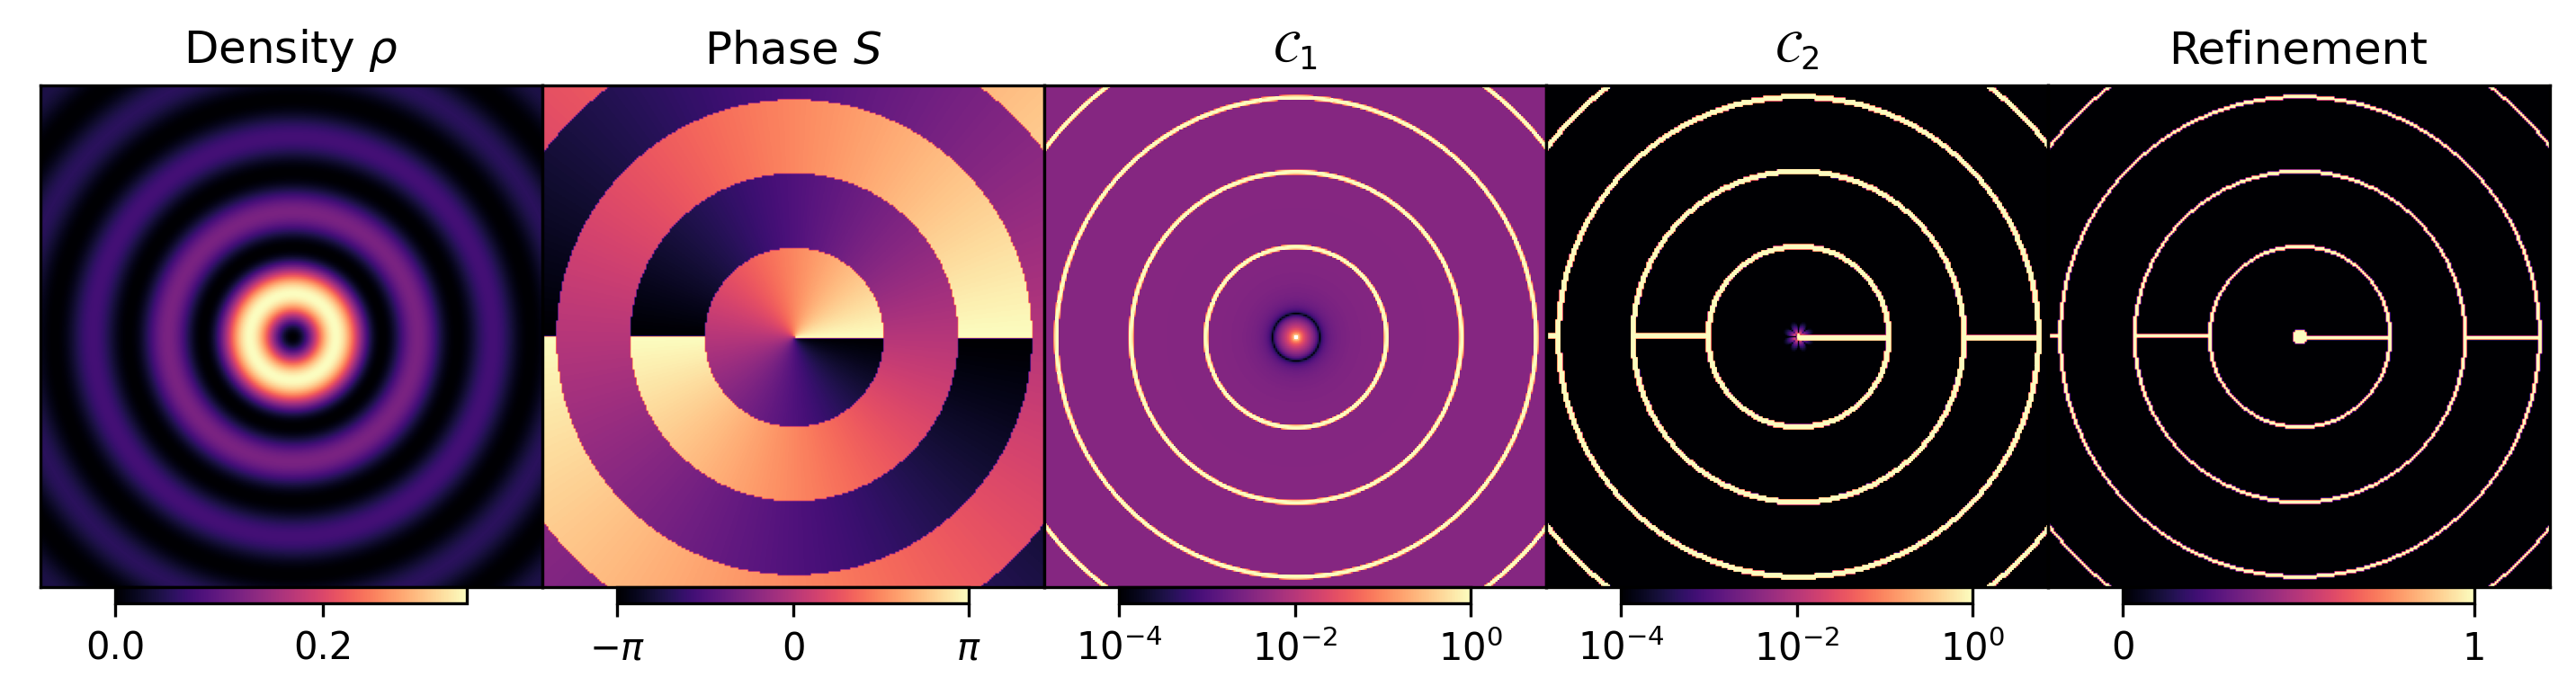

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.colors import LogNorm

# Function to generate the complex wave function based on the Schrödinger equation
def generate_wave_function(x, y, VorPairLin_kx = 1, VorPairLin_ky = 1, time = 0):
    # Given parameters
    if 0:
        VorPairLin_BgAmp = 1
        VorPairLin_WaveAmp = 1.0
        VorPairLin_Phase0 = 0.0
        VorPairLin_Omega = 0.5  # Simplified for demonstration

        phase = VorPairLin_kx * x - VorPairLin_Omega * time + VorPairLin_Phase0
        amp = VorPairLin_WaveAmp * np.cos(VorPairLin_ky * y)
        Re = VorPairLin_BgAmp + amp * np.cos(phase)
        Im = amp * np.sin(phase)
        return Re + 1j * Im

    else:
        VorPairRot_Omega = 90
        VorPairRot_Phase0 = 0
        VorPairRot_J1Amp = 1
        VorPairRot_BgAmp = 0

        dx = x
        dy = y
        phase = np.arctan2(dy, dx) - VorPairRot_Omega * Time + VorPairRot_Phase0
        R = np.sqrt(dx ** 2 + dy ** 2)
        J1 = VorPairRot_J1Amp * j1(np.sqrt(2.0 * ELBDM_ETA * VorPairRot_Omega) * R)
        Re = VorPairRot_BgAmp - J1 * np.cos(phase)
        Im = -J1 * np.sin(phase)
        return Re + 1j * Im

N = 256
# Grid setup
x = np.linspace(-0.8, 0.8, N, endpoint=False)
y = np.linspace(-0.8, 0.8, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wave function computation
psi = generate_wave_function(X, Y)
Re, Im = np.real(psi), np.imag(psi)

# Density calculation
density = Re**2 + Im**2
phase   = np.arctan2(Im, Re)

# Calculate C1
sqrt_density = np.sqrt(density)
C11 = np.diff(sqrt_density, n=2, axis=0)[:, 1:-1]
C12 = np.diff(sqrt_density, n=2, axis=1)[1:-1, :]
C1 = np.abs((C11 + C12)/2/sqrt_density[1:-1, 1:-1])


# Calculate C2
C21 = np.diff(phase, n=2, axis=0)[:, 1:-1]
C22 = np.diff(phase, n=2, axis=1)[1:-1, :]
C2 = np.abs((C21 + C22)/2)

# Sum of C1_avg and C2_avg
C3 = ((C1 > 0.03) + (C2 > 1.0))>0
cmap="magma"


# Create a figure with three subplots
fig = plt.figure(figsize=(12, 3), dpi=300)
gs = gridspec.GridSpec(2, 5, height_ratios=[10, 0.5], hspace=0.1, wspace=0.0)


# Function to adjust colorbar position and width
def add_colorbar(ax, im, width_shrink=0.75, pad=0.05):
    # Calculate new width and position
    ax_pos = ax.get_position()
    width = ax_pos.width * width_shrink
    x_position = ax_pos.x0 + (ax_pos.width - width) / 2  # Center the smaller colorbar
    cax = fig.add_axes([x_position, 0.2, width, 0.02])
    return plt.colorbar(im, cax=cax, orientation='horizontal')

# Add subplots
for i, data in enumerate([density, phase, C1, C2, C3]):
    ax = fig.add_subplot(gs[0, i])
    if i == 0:
        im = ax.imshow(data, cmap=cmap, vmax=10)
    if i == 1:
        im = ax.imshow(data, cmap=cmap, vmin = -np.pi*1.5, vmax = np.pi*1.5)
    if i == 2:
        im = ax.imshow(data, cmap=cmap, norm=LogNorm(vmin=1e-4, vmax=1e0))
    elif i == 3:
        im = ax.imshow(data, cmap=cmap, norm=LogNorm(vmin=1e-4, vmax=1e0))
    else:
        im = ax.imshow(data, cmap=cmap)

    ax.set_xticks([])
    ax.set_yticks([])

    # Add colorbar below each subplot

    # Adjust colorbar placement
    cbar = add_colorbar(ax, im, width_shrink=0.7, pad=0.0)


    if i == 0:
        ax.set_title(r'Density $\rho$')
    elif i == 1:
        ax.set_title(r'Phase $S$')
        cbar.ax.set_xticks([-np.pi, 0, np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])  # horizontal colorbar
    elif i == 2:
        ax.set_title(r'$\mathcal{C}_1$')
    elif i == 3:
        ax.set_title(r'$\mathcal{C}_2$')
    elif i == 4:
        ax.set_title('Refinement')
        cbar.ax.set_xticks([0, 1], [0, 1])  # horizontal colorbar


plt.savefig("plots/interference.pdf", bbox_inches='tight')
plt.show()

# Spectral refinement

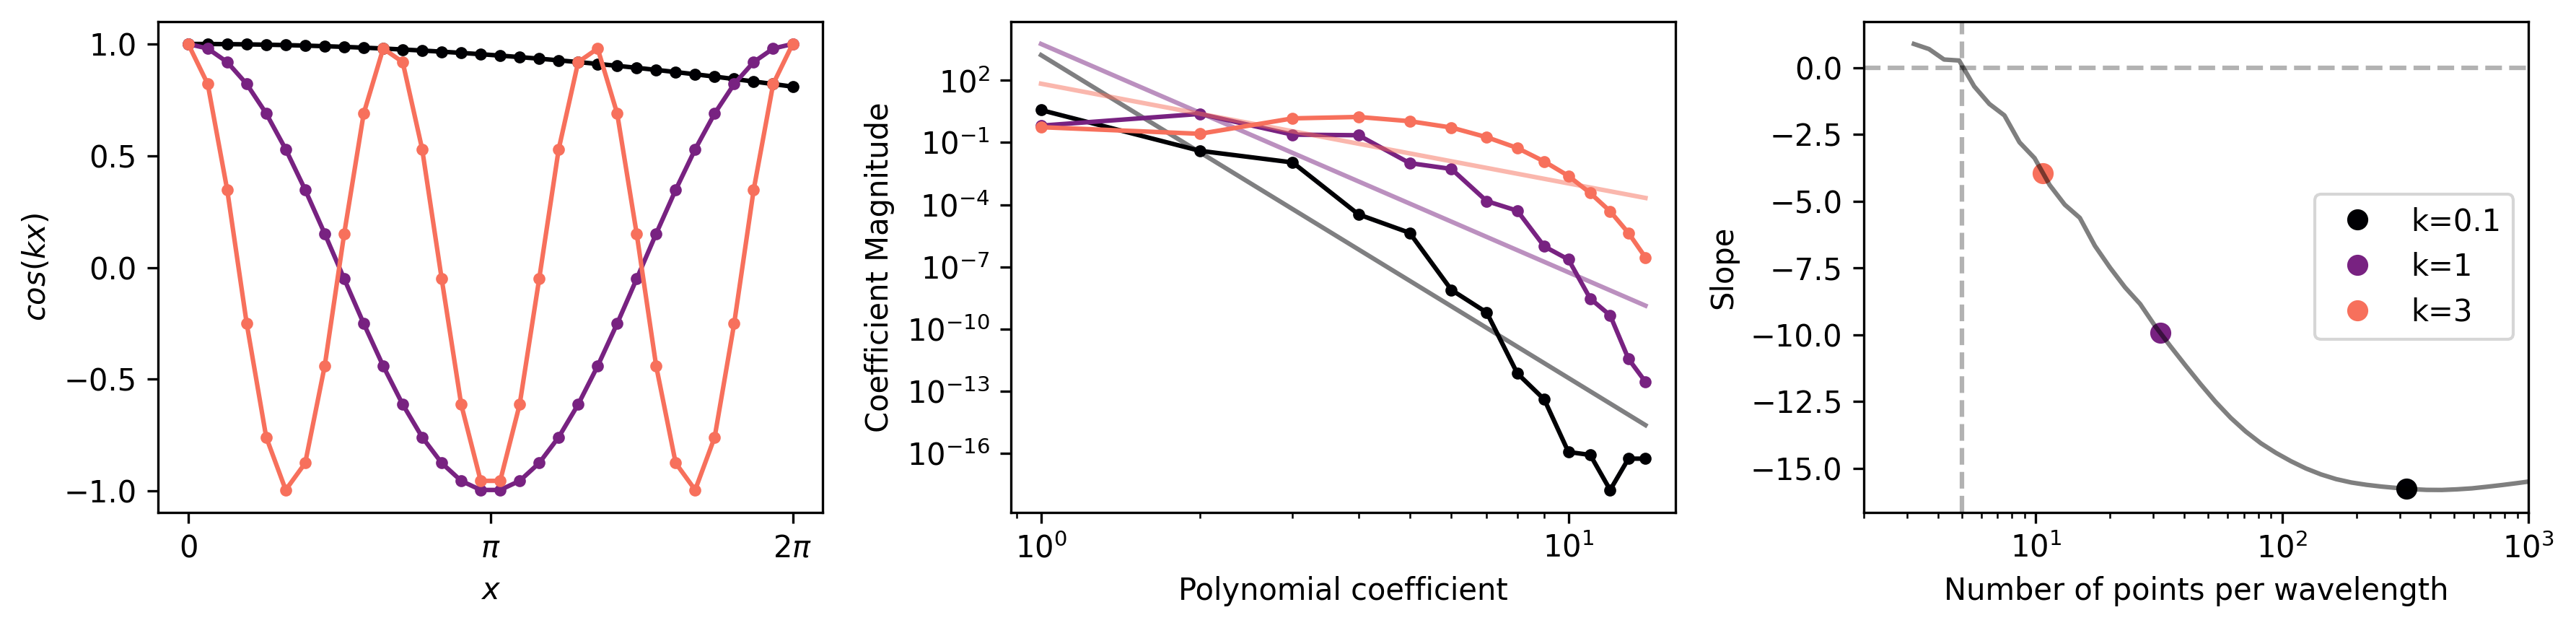

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec



# GramFE parameters for extension of size 14
FLAG_SPECTRAL_ORDER = 14
FLAG_SPECTRAL_NDELTA = 14
FLAG_SPECTRAL_ND = 32


flag_spectral_polynomials = np.array([
[0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000, 0.2672612419124243965384835064469370990991592407226562500000000000],
[-0.4309458036856673168735198942158604040741920471191406250000000000, -0.3646464492724877382023862537607783451676368713378906250000000000, -0.2983470948593081595312526133056962862610816955566406250000000000, -0.2320477404461285531045433572217007167637348175048828125000000000, -0.1657483860329489744334097167666186578571796417236328125000000000, -0.0994490316197693818844882684970798436552286148071289062500000000, -0.0331496772065897962744607241347694071009755134582519531250000000, 0.0331496772065897962744607241347694071009755134582519531250000000, 0.0994490316197693818844882684970798436552286148071289062500000000, 0.1657483860329489744334097167666186578571796417236328125000000000, 0.2320477404461285531045433572217007167637348175048828125000000000, 0.2983470948593081595312526133056962862610816955566406250000000000, 0.3646464492724877382023862537607783451676368713378906250000000000, 0.4309458036856673168735198942158604040741920471191406250000000000],
[0.4818120558297157574045854744326788932085037231445312500000000000, 0.2594372608313854078332383323868270963430404663085937500000000000, 0.0741249316661101165237823806819505989551544189453125000000000000, -0.0741249316661101165237823806819505989551544189453125000000000000, -0.1853123291652752913094559517048764973878860473632812500000000000, -0.2594372608313854078332383323868270963430404663085937500000000000, -0.2964997266644404660951295227278023958206176757812500000000000000, -0.2964997266644404660951295227278023958206176757812500000000000000, -0.2594372608313854078332383323868270963430404663085937500000000000, -0.1853123291652752913094559517048764973878860473632812500000000000, -0.0741249316661101165237823806819505989551544189453125000000000000, 0.0741249316661101165237823806819505989551544189453125000000000000, 0.2594372608313854078332383323868270963430404663085937500000000000, 0.4818120558297157574045854744326788932085037231445312500000000000],
[-0.4585783658733355583336788185988552868366241455078125000000000000, -0.0352752589133335028859228543751669349148869514465332031250000000, 0.2116515534800010311933249340654583647847175598144531250000000000, 0.3142704885006075699038774473592638969421386718750000000000000000, 0.3046499633424257225122744330292334780097007751464843750000000000, 0.2148583951993949803238592721754685044288635253906250000000000000, 0.0769642012654549179107021927848109044134616851806640625000000000, -0.0769642012654549179107021927848109044134616851806640625000000000, -0.2148583951993949803238592721754685044288635253906250000000000000, -0.3046499633424257225122744330292334780097007751464843750000000000, -0.3142704885006075699038774473592638969421386718750000000000000000, -0.2116515534800010311933249340654583647847175598144531250000000000, 0.0352752589133335028859228543751669349148869514465332031250000000, 0.4585783658733355583336788185988552868366241455078125000000000000],
[0.3875694570442999031811837085115257650613784790039062500000000000, -0.2086912461007768837539799733349354937672615051269531250000000000, -0.3577564218870460943655587016110075637698173522949218750000000000, -0.2493453849515775699874353676932514645159244537353515625000000000, -0.0352335870040272683412219123511022189632058143615722656250000000, 0.1707473831733629099360882719338405877351760864257812500000000000, 0.2927097997257649963920300706377020105719566345214843750000000000, 0.2927097997257649963920300706377020105719566345214843750000000000, 0.1707473831733629099360882719338405877351760864257812500000000000, -0.0352335870040272683412219123511022189632058143615722656250000000, -0.2493453849515775699874353676932514645159244537353515625000000000, -0.3577564218870460943655587016110075637698173522949218750000000000, -0.2086912461007768837539799733349354937672615051269531250000000000, 0.3875694570442999031811837085115257650613784790039062500000000000],
[-0.2948961391092899120280890201684087514877319335937500000000000000, 0.3856334126813791285393051566643407568335533142089843750000000000, 0.2722118207162676495336484094877960160374641418457031250000000000, -0.0577419013640567690970328840194270014762878417968750000000000000, -0.2866472960572818418079066304926527664065361022949218750000000000, -0.2990205606352939748937558306352002546191215515136718750000000000, -0.1237326457801216500476115811579802539199590682983398437500000000, 0.1237326457801216500476115811579802539199590682983398437500000000, 0.2990205606352939748937558306352002546191215515136718750000000000, 0.2866472960572818418079066304926527664065361022949218750000000000, 0.0577419013640567690970328840194270014762878417968750000000000000, -0.2722118207162676495336484094877960160374641418457031250000000000, -0.3856334126813791285393051566643407568335533142089843750000000000, 0.2948961391092899120280890201684087514877319335937500000000000000],
[0.2027563273040598468277551091887289658188819885253906250000000000, -0.4523025762936719873508195632894057780504226684570312500000000000, -0.0155966405618507587826915283812923007644712924957275390625000000, 0.3218579461400111196844875394162954762578010559082031250000000000, 0.2623071367220354832561213243025122210383415222167968750000000000, -0.0354469103678426294967707121941202785819768905639648437500000000, -0.2835752829427410359741656975529622286558151245117187500000000000, -0.2835752829427410359741656975529622286558151245117187500000000000, -0.0354469103678426294967707121941202785819768905639648437500000000, 0.2623071367220354832561213243025122210383415222167968750000000000, 0.3218579461400111196844875394162954762578010559082031250000000000, -0.0155966405618507587826915283812923007644712924957275390625000000, -0.4523025762936719873508195632894057780504226684570312500000000000, 0.2027563273040598468277551091887289658188819885253906250000000000],
[-0.1257441362172087295778766247167368419468402862548828125000000000, 0.4159229121030749709575502492953091859817504882812500000000000000, -0.2611608982972796755284150549414334818720817565917968750000000000, -0.3104033572354872316800822318327846005558967590332031250000000000, 0.0835363142701736199891016099172702524811029434204101562500000000, 0.3297486089612116644254058428487041965126991271972656250000000000, 0.1758659247793128987957800291042076423764228820800781250000000000, -0.1758659247793128987957800291042076423764228820800781250000000000, -0.3297486089612116644254058428487041965126991271972656250000000000, -0.0835363142701736199891016099172702524811029434204101562500000000, 0.3104033572354872316800822318327846005558967590332031250000000000, 0.2611608982972796755284150549414334818720817565917968750000000000, -0.4159229121030749709575502492953091859817504882812500000000000000, 0.1257441362172087295778766247167368419468402862548828125000000000],
[0.0699086407042275592704783093722653575241565704345703125000000000, -0.3172776770422635062018912321946118026971817016601562500000000000, 0.4248294319718443623479231519013410434126853942871093750000000000, 0.0376431142253532968755536103344638831913471221923828125000000000, -0.3495432035211377685968159312324132770299911499023437500000000000, -0.1344396936619760840603277074478683061897754669189453125000000000, 0.2688793873239521681206554148957366123795509338378906250000000000, 0.2688793873239521681206554148957366123795509338378906250000000000, -0.1344396936619760840603277074478683061897754669189453125000000000, -0.3495432035211377685968159312324132770299911499023437500000000000, 0.0376431142253532968755536103344638831913471221923828125000000000, 0.4248294319718443623479231519013410434126853942871093750000000000, -0.3172776770422635062018912321946118026971817016601562500000000000, 0.0699086407042275592704783093722653575241565704345703125000000000],
[-0.0344591278812576007339885109104216098785400390625000000000000000, 0.2041040651428334962158572807311429642140865325927734375000000000, -0.4320644495880761049022567021893337368965148925781250000000000000, 0.2836251294841972137028562883642734959721565246582031250000000000, 0.2359124908793789887617720069101778790354728698730468750000000000, -0.2783237251947729418155574876436730846762657165527343750000000000, -0.2385631930240910969498457916415645740926265716552734375000000000, 0.2385631930240910969498457916415645740926265716552734375000000000, 0.2783237251947729418155574876436730846762657165527343750000000000, -0.2359124908793789887617720069101778790354728698730468750000000000, -0.2836251294841972137028562883642734959721565246582031250000000000, 0.4320644495880761049022567021893337368965148925781250000000000000, -0.2041040651428334962158572807311429642140865325927734375000000000, 0.0344591278812576007339885109104216098785400390625000000000000000],
[0.0147897728358395794817647939112248423043638467788696289062500000, -0.1103544588520337932369130840015714056789875030517578125000000000, 0.3276503520555230086763742747280048206448554992675781250000000000, -0.4459685347422396306527048182033468037843704223632812500000000000, 0.1422093541907651914613097687833942472934722900390625000000000000, 0.3174112785537879233288549585267901420593261718750000000000000000, -0.2457377640416422426294928982315468601882457733154296875000000000, -0.2457377640416422426294928982315468601882457733154296875000000000, 0.3174112785537879233288549585267901420593261718750000000000000000, 0.1422093541907651914613097687833942472934722900390625000000000000, -0.4459685347422396306527048182033468037843704223632812500000000000, 0.3276503520555230086763742747280048206448554992675781250000000000, -0.1103544588520337932369130840015714056789875030517578125000000000, 0.0147897728358395794817647939112248423043638467788696289062500000],
[-0.0053617479838052716639706929413478064816445112228393554687500000, 0.0490806161594482537324779514165129512548446655273437500000000000, -0.1913731588065881450422267562316847033798694610595703125000000000, 0.3992440037171925415471207543305354192852973937988281250000000000, -0.4310020494674237645504888405412202700972557067871093750000000000, 0.0952741372506936690101042586320545524358749389648437500000000000, 0.3266541848595211350314571063790936022996902465820312500000000000, -0.3266541848595211350314571063790936022996902465820312500000000000, -0.0952741372506936690101042586320545524358749389648437500000000000, 0.4310020494674237645504888405412202700972557067871093750000000000, -0.3992440037171925415471207543305354192852973937988281250000000000, 0.1913731588065881450422267562316847033798694610595703125000000000, -0.0490806161594482537324779514165129512548446655273437500000000000, 0.0053617479838052716639706929413478064816445112228393554687500000],
[0.0015503894602372355823738381275234132772311568260192871093750000, -0.0170542840626095905387504814143539988435804843902587890625000000, 0.0837210308528107266523576868166856002062559127807617187500000000, -0.2387599768765342744814006437081843614578247070312500000000000000, 0.4263571015652398155104663146630628034472465515136718750000000000, -0.4604656696904589896490733735845424234867095947265625000000000000, 0.2046514087513151003427935847867047414183616638183593750000000000, 0.2046514087513151003427935847867047414183616638183593750000000000, -0.4604656696904589896490733735845424234867095947265625000000000000, 0.4263571015652398155104663146630628034472465515136718750000000000, -0.2387599768765342744814006437081843614578247070312500000000000000, 0.0837210308528107266523576868166856002062559127807617187500000000, -0.0170542840626095905387504814143539988435804843902587890625000000, 0.0015503894602372355823738381275234132772311568260192871093750000],
[-0.0003100778920474471056327459006496383153717033565044403076171875, 0.0040310125966168128611166743269222934031859040260314941406250000, -0.0241860755797008754319765699847266660071909427642822265625000000, 0.0886822771255698777403964072618691716343164443969726562500000000, -0.2217056928139246874120971142474445514380931854248046875000000000, 0.3990702470650644428928899287711828947067260742187500000000000000, -0.5320936627534192941979540592001285403966903686523437500000000000, 0.5320936627534192941979540592001285403966903686523437500000000000, -0.3990702470650644428928899287711828947067260742187500000000000000, 0.2217056928139246874120971142474445514380931854248046875000000000, -0.0886822771255698777403964072618691716343164443969726562500000000, 0.0241860755797008754319765699847266660071909427642822265625000000, -0.0040310125966168128611166743269222934031859040260314941406250000, 0.0003100778920474471056327459006496383153717033565044403076171875],
])


# Define least squares regression function
def least_squares_regression(x, y, start, end):
    x, y = np.asarray(x), np.asarray(y)
    x = x[start:end]
    y = y[start:end]
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x_squared = np.sum(x ** 2)
    sum_xy = np.sum(x * y)
    slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x_squared - sum_x ** 2)
    intercept = (sum_y - slope * sum_x) / n
    return slope, intercept

# Sample data
size_1d = 32
x = np.linspace(0, 2 * np.pi, size_1d)
ks = [0.1, 1, 3]  # Different values of k for the third plot
#colors = ['b', 'g', 'r']  # Colors for different k values
colors = plt.cm.magma(np.array([0, 0.35, 0.7]))

fig = plt.figure(figsize=(12, 3), dpi=300)
gs = GridSpec(1, 3)

# Plot 1: y over x
ax1 = fig.add_subplot(gs[0, 0])
for k, color in zip(ks, colors):
    y = np.exp(1j * x * k)
    ax1.plot(x, np.real(y), '.-', label=f'k={k}', color=color)
#ax1.set_title('Real part of exp(1j * x * k)')
ax1.set_xticks([0, np.pi, 2*np.pi], [r"$0$", r"$\pi$", r"$2\pi$"])
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$cos(k x)$')


# Plot 2: Polynomial coefficients and decay
ax2 = fig.add_subplot(gs[0, 1])

for k, color in zip(ks, colors):
    y         = np.exp(1j * x * k)
    max_order = 14
    al_re     = np.zeros(max_order)
    row_re    = np.real(y)

    # Calculate polynomial coefficients
    for i in range(max_order):
        for t in range(max_order):
            al_re[i] += flag_spectral_polynomials[i][t] * row_re[t]  # Using some index range

    order     = np.arange(1, max_order+1)
    al_re_log = np.log(np.abs(al_re) + 1e-14)

    ax2.plot(order, np.abs(al_re), '.-', label=f'k={k} |Coefficients|', color=color)
    slope, intercept = least_squares_regression(np.log(order), al_re_log, start=0, end=14)
    ax2.plot(order, np.exp(intercept) * order**slope, label=f'k={k} Fit: y ~ x^{slope:.2f}', color=color, alpha=0.5)
#ax2.set_title('Polynomial Coefficients Decay')
ax2.set_xlabel('Polynomial coefficient')
ax2.set_ylabel('Coefficient Magnitude')
ax2.set_yscale('log')
ax2.set_xscale('log')

# Plot 3: Slope as a function of k
ax3 = fig.add_subplot(gs[0, 2])
slopes = []
for k, color in zip(ks, colors):
    y = np.exp(1j * x * k)
    row_re = np.real(y)
    al_re = np.zeros(max_order)
    for i in range(max_order):
        al_re[i] = np.dot(flag_spectral_polynomials[i], row_re[:max_order])  # simplified for clarity
    al_re_log = np.log(np.abs(al_re) + 1e-14)
    slope, _ = least_squares_regression(np.log(order), al_re_log, start=0, end=-1)
    slopes.append(slope)
    ax3.plot(size_1d/k, slope, 'o', color=color, label=f'k={k}')

slopes = []
ks = np.logspace(-2, 1, 50)
for k in ks:
    y = np.exp(1j * x * k)
    row_re = np.real(y)
    al_re = np.zeros(max_order)
    for i in range(max_order):
        al_re[i] = np.dot(flag_spectral_polynomials[i], row_re[:max_order])  # simplified for clarity
    al_re_log = np.log(np.abs(al_re) + 1e-14)
    slope, _ = least_squares_regression(np.log(order), al_re_log, start=0, end=-1)
    slopes.append(slope)
ax3.plot(size_1d/ks, slopes, c="k", alpha=0.5)
ax3.axvline(x = 5, c="k", ls = "dashed", alpha=0.3)
ax3.axhline(y = 0, c="k", ls = "dashed", alpha=0.3)
ax3.set_xscale("log")
ax3.set_xlim([2, 1000])
#ax3.set_title('Slope of Fit vs. k')
ax3.set_xlabel('Number of points per wavelength')
ax3.set_ylabel('Slope')
ax3.legend()

plt.savefig("plots/spectral_refinement.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

# Error vs Wavelength

## Combine plane wave data

In [164]:

# Directory where your CSV files are stored
directory_path = 'results'


# Pattern to match CSV files
pattern = os.path.join(directory_path, 'results_*.csv')

# List all CSV files in the directory
csv_files = glob.glob(pattern)

# Initialize an empty DataFrame to store combined data
combined_df = pd.DataFrame()

# Read each CSV file, assign a manual label, and append to combined DataFrame
for file in csv_files:
    # Extract base filename without directory and extension to match with labels
    base_filename = os.path.basename(file)[:-4]  # Remove the last 4 characters (.csv)
    if base_filename in labels:
        # Read CSV file
        df = pd.read_csv(file)
        # Assign label
        df['Label'] = labels[base_filename]
        # Append to combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)


# Sort the DataFrame by PWave_NWavelength for consistent plotting
combined_df.sort_values('PWave_NWavelength', inplace=True)

combined_df.to_csv("results/results_planewave_wavelength.csv")

## Gaussian wave packet

### Derive relationship between velocity and minimum wavelength

       Coord.      Real      Imag     Phase
NaN  0.003906 -0.665369 -0.926940 -2.193377
NaN  0.011719 -0.094574 -1.246837 -1.646502
NaN  0.019531  0.618234 -1.213561 -1.099627
NaN  0.027344  1.254864 -0.774123 -0.552752
NaN  0.035156  1.586448 -0.009324 -0.005877
..        ...       ...       ...       ...
NaN  0.964844  0.140779  0.643545  1.355433
NaN  0.972656 -0.242247  0.703767  1.902308
NaN  0.980469 -0.643331  0.533576  2.449183
NaN  0.988281 -0.923007  0.135286  2.996058
NaN  0.996094 -0.952631 -0.404272 -2.740252

[128 rows x 4 columns]
Minimum Wavelength: 0.0859375


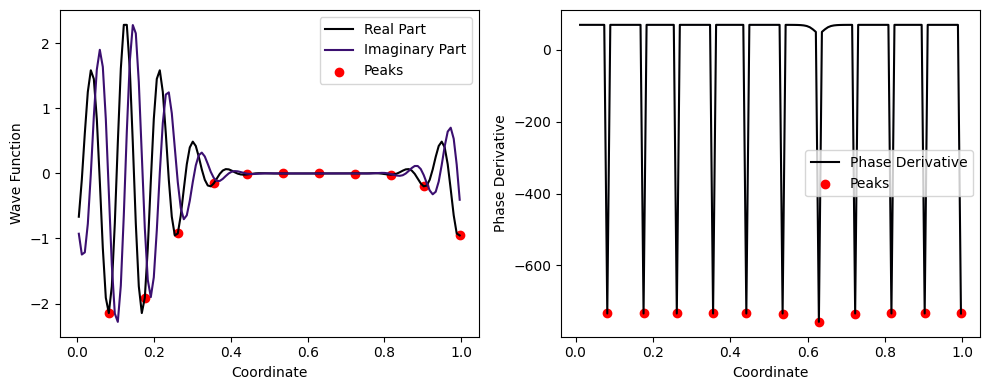

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Placeholder for reading your CSV (make sure to have your actual path here)
df = pd.read_csv("results/Gaussian_Imag_000000", delimiter=" ")
df = df.sort_values(by='Coord.')

# Assuming df is your DataFrame and it has 'Coord.' and 'Analytical' columns
coords = df["Coord."]
imag   = df["Analytical"]

df     = pd.read_csv("results/Gaussian_Real_000000", delimiter=" ")
df     = df.sort_values(by='Coord.')
real   = df["Analytical"]

df = pd.DataFrame({"Coord.": coords, "Real": real, "Imag": imag})
# Calculate the phase of the wave function
df['Phase'] = np.arctan2(df['Imag'], df['Real'])
print(df)

# Calculate the derivative of the phase with respect to the coordinate
# Note: Ensure coordinates are sorted
df = df.sort_values(by='Coord.')
phase_derivative = np.diff(df['Phase'].to_numpy()) / np.diff(df['Coord.'].to_numpy())

# Detect peaks: where the derivative of the phase changes sign
sign_changes = phase_derivative < -100

# Adjust peak indices by +1 due to the way np.diff() reduces array size
peak_indices = np.where(sign_changes)[0] + 1

# Assuming 'df' is your DataFrame with 'Coord.', 'Real', and 'Imag' columns
# and 'peak_indices' contains the indices of identified peaks in the phase

# Extract coordinates of identified peaks
peak_coords = df.iloc[peak_indices]['Coord.']

# Calculate distances between successive peaks
distances_between_peaks = np.diff(peak_coords.to_numpy())

# The minimum wavelength is the smallest of these distances
min_wavelength = np.min(distances_between_peaks) if distances_between_peaks.size > 0 else np.nan

# Output the minimum wavelength
print("Minimum Wavelength:", min_wavelength)

# Plotting for visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(df['Coord.'], df['Real'], label='Real Part')
plt.plot(df['Coord.'], df['Imag'], label='Imaginary Part')
plt.scatter(df.iloc[peak_indices]['Coord.'], df.iloc[peak_indices]['Real'], color='red', label='Peaks')
plt.xlabel('Coordinate')
plt.ylabel('Wave Function')
plt.legend()


# Plotting phase derivative with peaks correctly
plt.subplot(1, 2, 2)
plt.plot(df['Coord.'].iloc[1:], phase_derivative, label='Phase Derivative')  # Adjusted for phase_derivative indexing
# Since peak_indices are for df, align peak_coords for plotting on phase_derivative
plt.scatter(peak_coords, [phase_derivative[i-1] for i in peak_indices], color='red', label='Peaks')  # Corrected
plt.xlabel('Coordinate')
plt.ylabel('Phase Derivative')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
128 * min_wavelength / 0.077426, 128 * min_wavelength / 0.599484, 128 * min_wavelength / 1.66816

(142.0711388939116, 18.349113571004395, 6.594091693842317)

In [178]:
128 * min_wavelength / 0.077426, 128 * min_wavelength / 0.599484, 128 * min_wavelength / 1.66816

(1280.0, 1.0)


128 * min_wavelength / 0.077426, 128 * min_wavelength / 0.599484, 128 * min_wavelength / 1.66816
142.0711388939116, 18.349113571004395, 6.594091693842317

### Plot error vs minimum wavelength

Plot saved as 'errors_vs_wavelength.pdf'


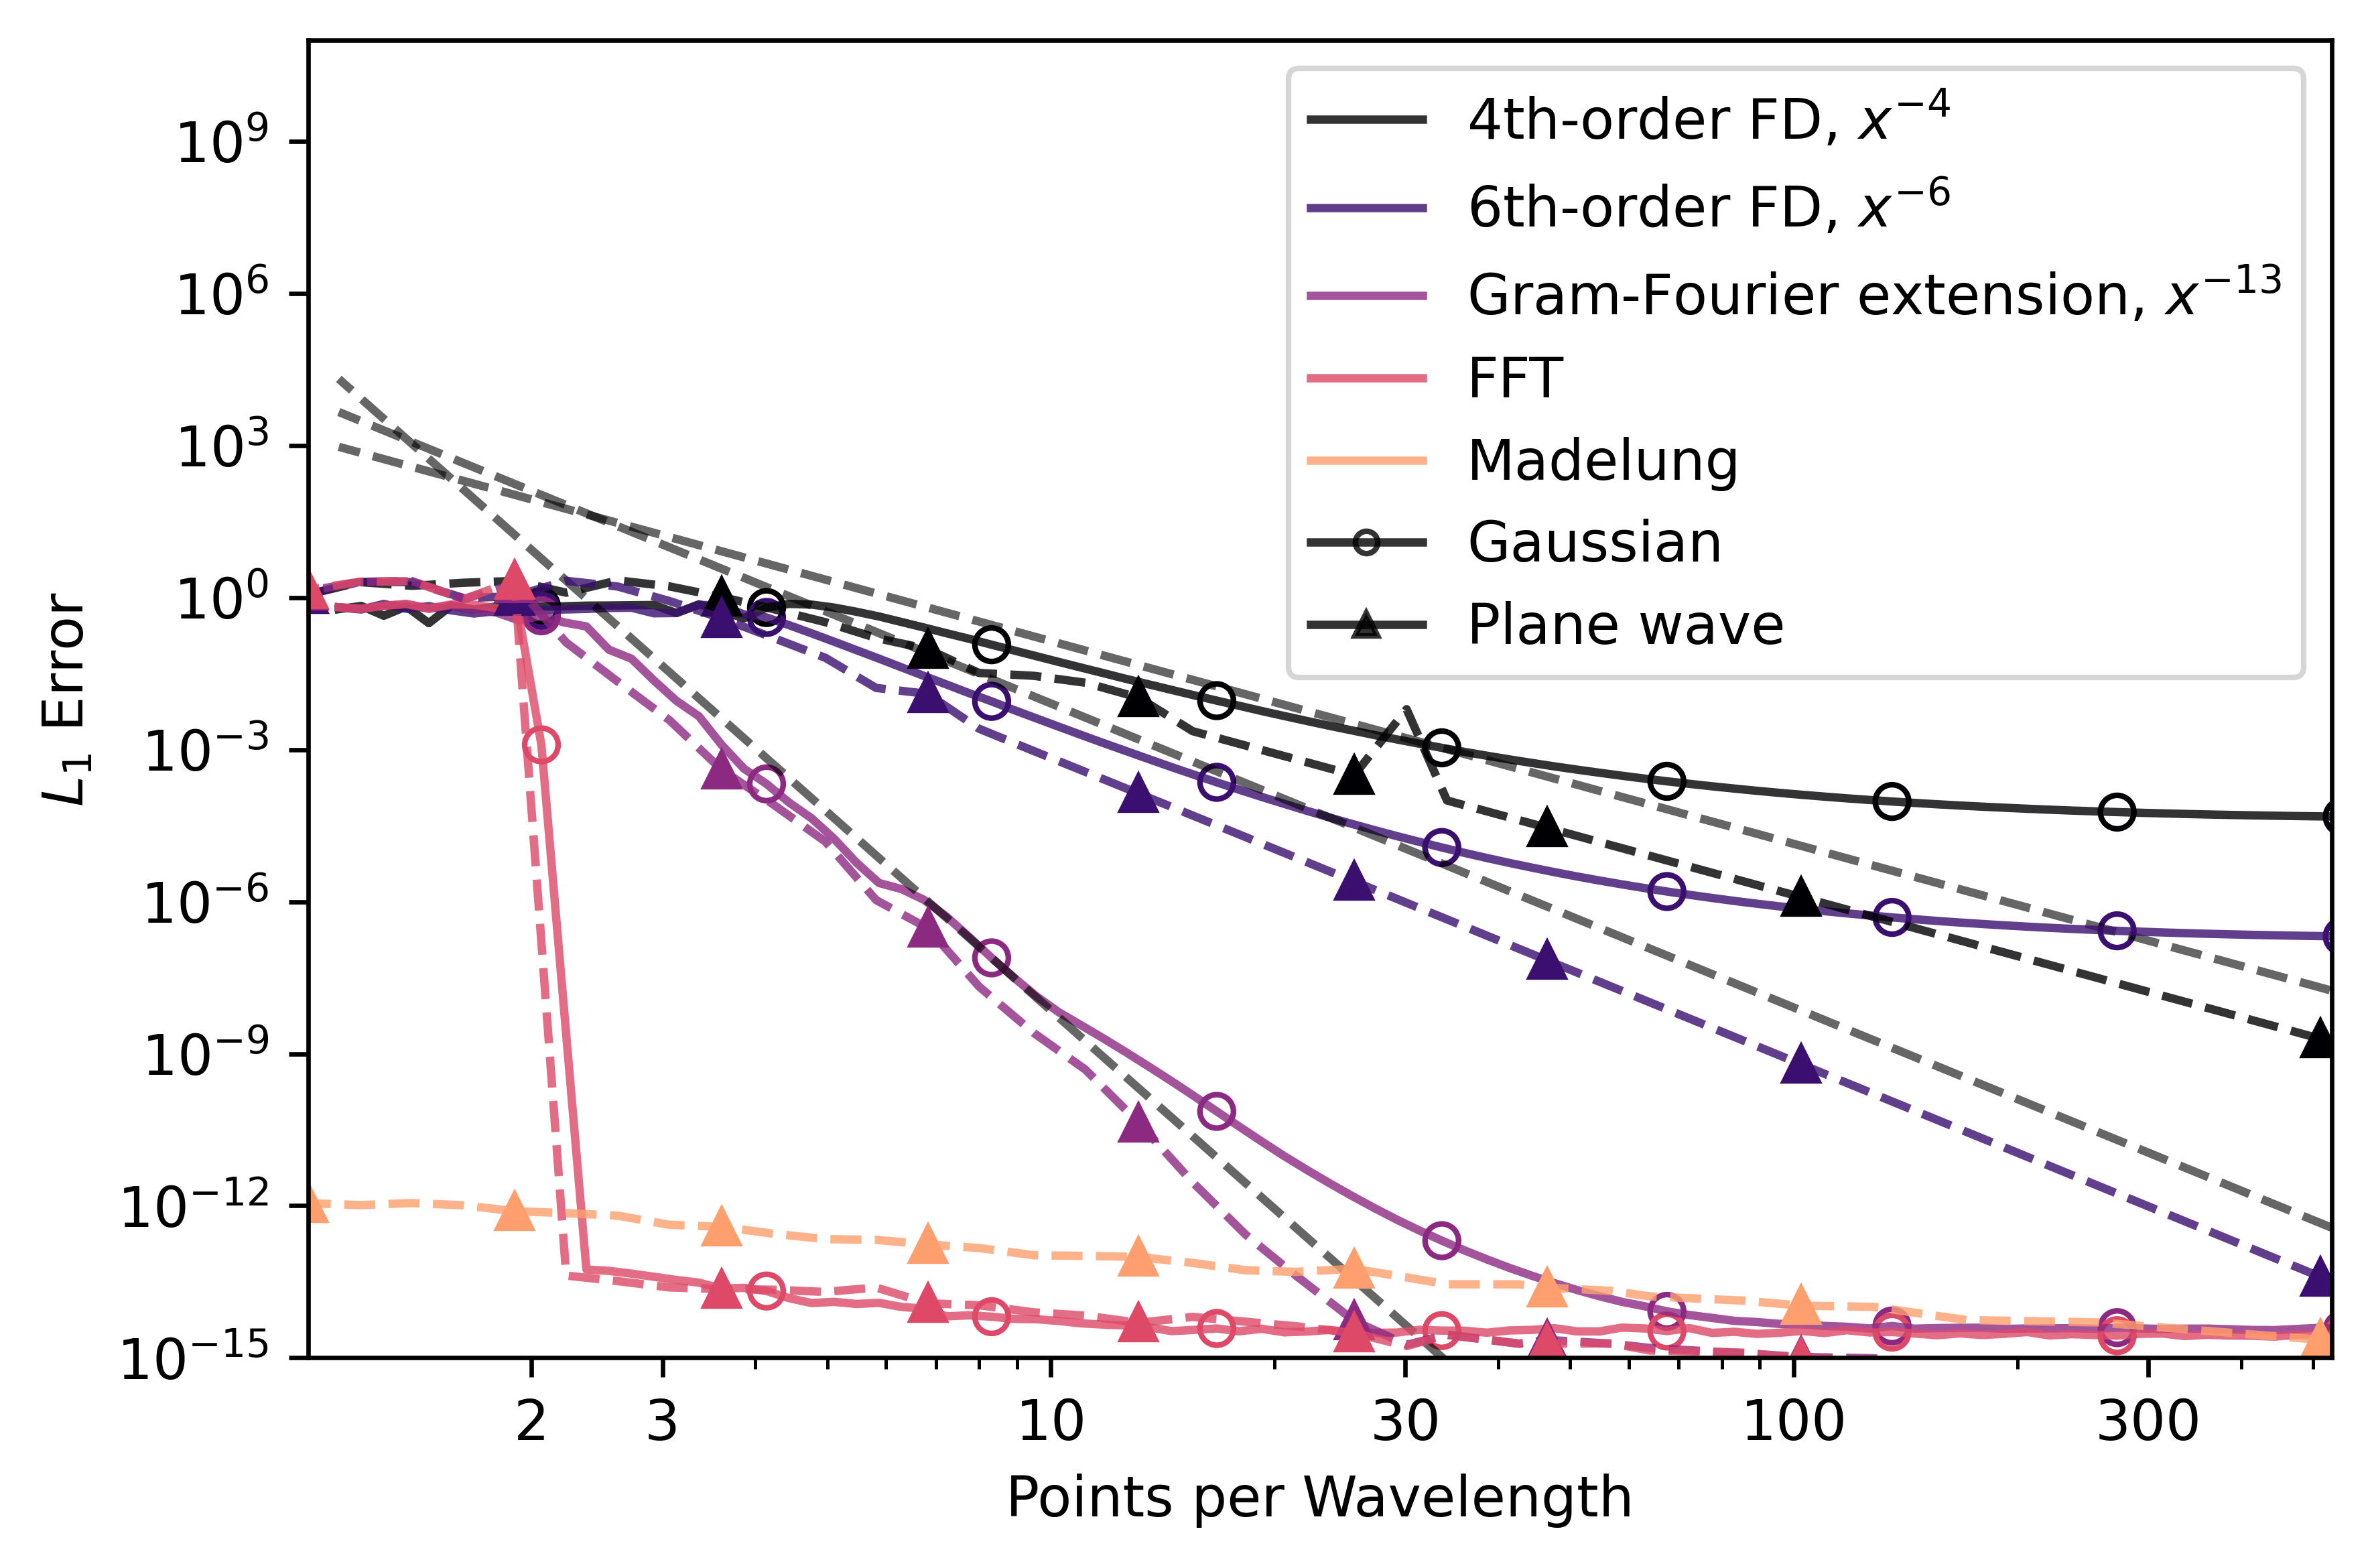

In [184]:

set_cycle(6)
# Path to the CSV file
csv_file_path = 'results/results_gaussian_wavelength.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Manually specify labels for each run based on the 'RunName'
labels = {
    'fd_2_Gau_v0': '4th-order FD, $x^{-4}$',
    'fd_4_Gau_v0': '6th-order FD, $x^{-6}$',
    'gramfe_fft_Gau_v0': 'Gram-Fourier extension, $x^{-13}$',
    'base_fft_Gau_v0': 'FFT',
    # Add more mappings as needed
}

# Assign labels based on 'RunName'
df['Label'] = df['RunName'].map(labels)

# Sort the DataFrame by Velocity for consistent plotting
df.sort_values('Velocity', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4), dpi=600)  # High-resolution plot

N_points = 128

desired_order = [labels["fd_2_Gau_v0"], labels["fd_4_Gau_v0"], labels["gramfe_fft_Gau_v0"], labels["base_fft_Gau_v0"], "Madelung"]  # Update this list to your desired order of labels

# Convert the 'Label' column to a categorical type with the specified order
df['Label'] = pd.Categorical(df['Label'], categories=desired_order, ordered=True)


# Plot data for each label
for label, group_df in df.groupby('Label'):
    x = N_points * min_wavelength / group_df['Velocity']
    y = 0.5 * (group_df['Error(Real)'] + group_df['Error(Imag)'])
    line, = plt.plot(x, y, label=f'{label}', linestyle='-', alpha = 0.8)
    plt.scatter(x[::10], y[::10], facecolors='none', alpha = 1, edgecolors=line.get_color())

    # Plotting reference lines based on label
    if label == '4th-order FD, $x^{-4}$':
        y_ref = y.iloc[50] * (x/x.iloc[50])**-4
        plt.plot(x, y_ref, 'k--', alpha = 0.6)
    elif label == '6th-order FD, $x^{-6}$':
        y_ref = y.iloc[55] * (x/x.iloc[55])**-6
        plt.plot(x, y_ref, 'k--', alpha = 0.6)
    elif label == 'Gram-Fourier extension, $x^{-13}$':
        y_ref = y.iloc[70] * (x/x.iloc[70])**-13
        plt.plot(x, y_ref, 'k--', alpha = 0.6)

plt.gca().set_prop_cycle(None)


# Path to the CSV file
csv_file_path = 'results/results_planewave_wavelength.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)
N_points = 512


# Manually specify labels for each CSV file (base filename without directory and extension)
labels = {
    'base_fft_PWave_NWavelength': 'FFT',
    'fd_2_PWave_NWavelength': '4th-order FD, $x^{-4}$',
    'fd_4_PWave_NWavelength': '6th-order FD, $x^{-6}$',
    'gramfe_fft_PWave_NWavelength': 'Gram-Fourier extension, $x^{-13}$',
    'fluid_PWave_NWavelength': 'Madelung',
    # Add more mappings as needed
}

# Assign labels based on 'RunName'
df['Label'] = df['RunName'].map(labels)
# Convert the 'Label' column to a categorical type with the specified order
df['Label'] = pd.Categorical(df['Label'], categories=desired_order, ordered=True)

# Sorting by x
df = df.sort_values(by='Wavelength')

# Plot data for each label
for label, group_df in df.groupby('Label'):
    x = N_points / group_df['Wavelength']
    y = 0.5 * (group_df['Error(Dens)'] + group_df['Error(Real)'])
    # Sort x and re-arrange y accordingly
    indices = np.argsort(x)

    # Calculate logarithmically spaced indices based on the length of k, avoiding log10(0)
    indices = np.arange(0, len(x), 4)#np.geomspace(1, len(x), num=10, dtype=int) - 1  # Subtract 1 to adjust for index starting at 0
    # Ensure unique indices if overlapping occurs due to rounding and bounds
    unique_indices = np.unique(indices)

    line, = plt.plot(x, y, linestyle='--', alpha = 0.8)
    line, = plt.plot(x.array[unique_indices], y.array[unique_indices], marker='^', linestyle='', alpha = 1, color=line.get_color())


plt.xlabel('Points per Wavelength')
plt.ylabel('$L_1$ Error')
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-15, 1e11])
plt.xlim([1, 530])

# Optional: Customizing tick labels for clarity
plt.xticks([2, 3, 10, 30, 100, 300], ['2','3','10','30','100','300'])

# Create the initial legend
legend1 = plt.legend(loc="upper right")

# Define custom legend handles
custom_handles = [
    Line2D([0], [0], marker='o', color='k', alpha =0.8, markersize=4, markerfacecolor='none', label='Gaussian'),
    Line2D([0], [0], marker='^', color='k', alpha =0.8, markersize=4, label='Plane wave')
]

# Retrieve handles and labels from the existing legend
handles1, labels1 = ax.get_legend_handles_labels()

# Combine original handles/labels with the new custom ones
handles_combined = handles1 + custom_handles
labels_combined = labels1 + [handle.get_label() for handle in custom_handles]

# Create a new legend that includes the original and new entries
plt.legend(handles=handles_combined, labels=labels_combined, loc='upper right')


# Show or save the plot
plt.tight_layout()
plt.savefig('plots/gaussian_errors_vs_wavelength.pdf')  # Save the plot as a PNG file
# plt.show()  # Uncomment to display the plot instead

print("Plot saved as 'errors_vs_wavelength.pdf'")


# Gaussian lag

/tmp/ipykernel_23888/607696834.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title if needed


Plot saved as plots/analytical_vs_numerical_densities_with_error.pdf


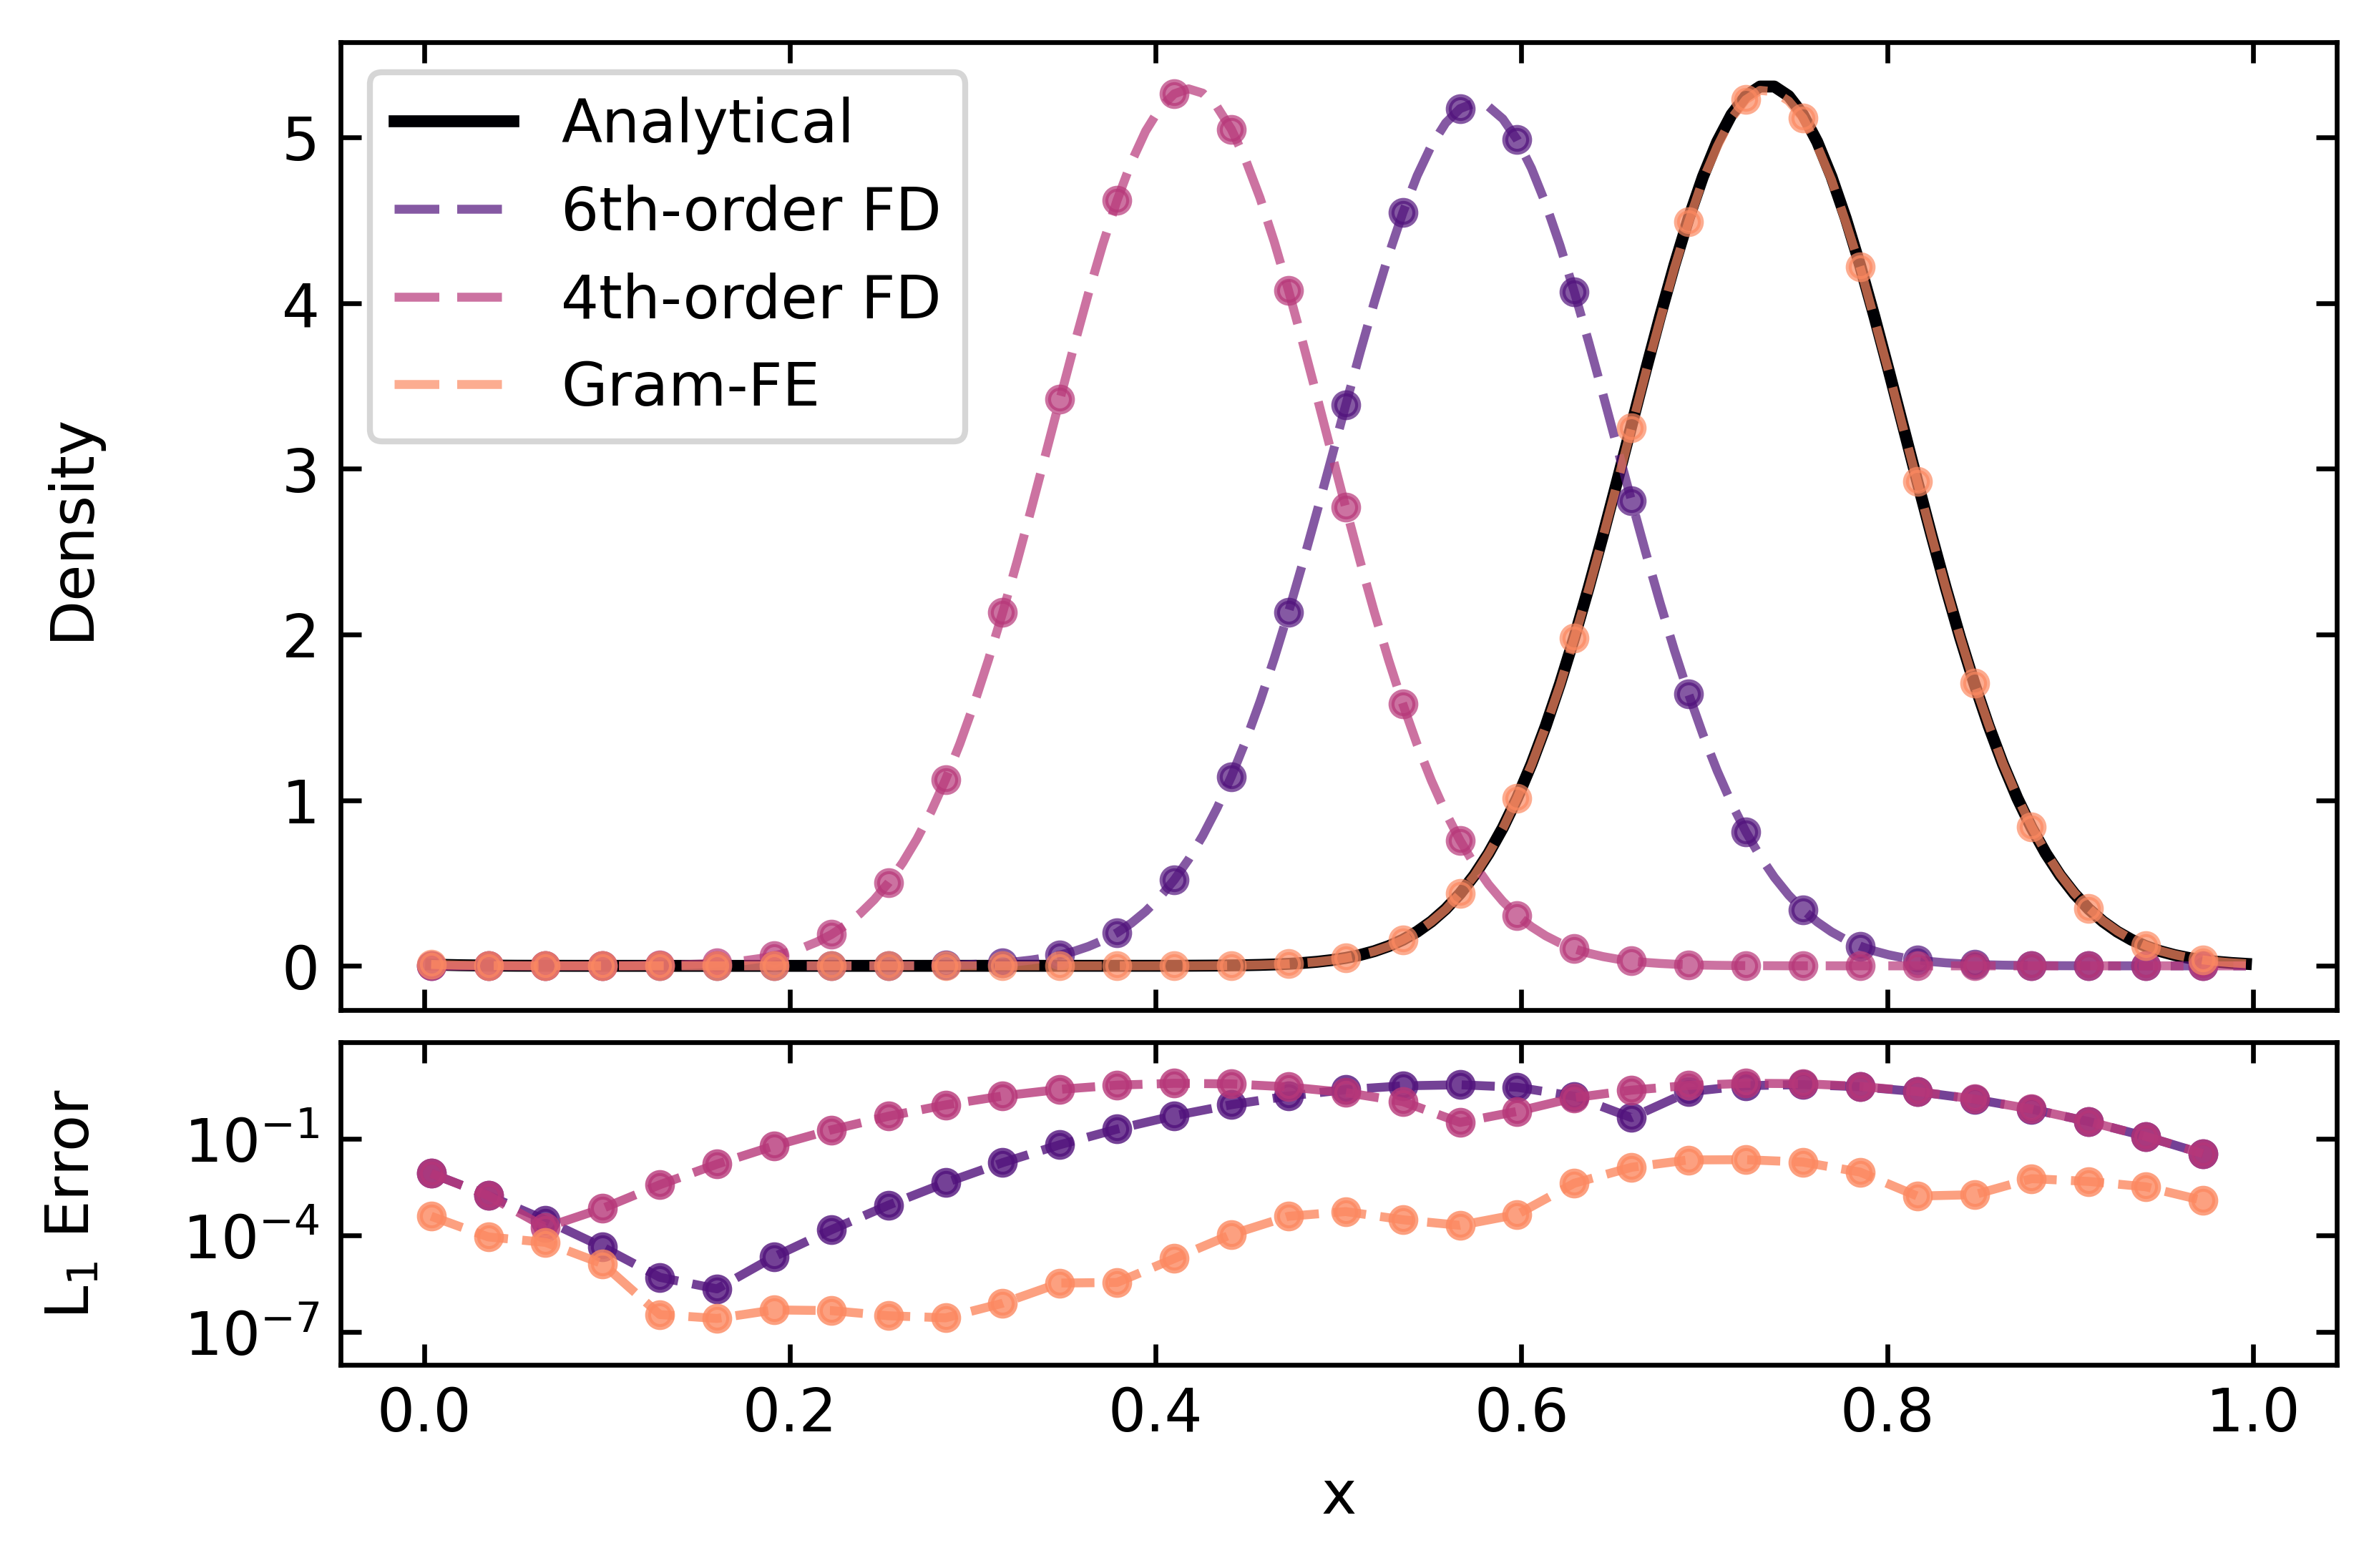

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load the DataFrame from the CSV file
csv_filename = 'results/combined_density_0_10_t=0.5.csv'  # Update this to your CSV file name
df = pd.read_csv(csv_filename)
# Specify the index of interest
index_of_interest = 5  # Example index, adjust according to your data
set_cycle(5)

# Filter the DataFrame to include only the data for the specified index
df = df[df['Index'] == index_of_interest]

shift_left = -18

# Create a figure with two subplots that share the x-axis
fig = plt.figure(figsize=(6, 4), dpi=600)  # Increase figure height to accommodate both plots
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)  # Adjust subplot sizes and spacing
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

# Choose a source for the analytical density - let's say the first one in the DataFrame
unique_sources = df['Source'].unique()
analytical_source = unique_sources[0]  # Adjust if you prefer a different source

# Plot the analytical density from the chosen source on the first subplot
df_analytical = df[df['Source'] == analytical_source]
df_analytical = df_analytical.sort_values("Coord.")
ana = np.roll( df_analytical['Analytical'], shift_left)
ax1.plot(df_analytical['Coord.'], ana, label='Analytical', linestyle='-', linewidth=2)

labels = {
    "fd_2_results": "4th-order FD",
    "fd_4_results": "6th-order FD",
    "gramfe_fft_results": "Gram-FE",
    "base_fft_results": "FFT",
}

# Plot numerical densities from all sources on the first subplot
for source in unique_sources:
    if source == "base_fft_results":
        continue
    df_source = df[df['Source'] == source]
    df_source = df_source.sort_values("Coord.")
    #ax1.plot(df_source['Coord.'], df_source['Numerical'], label=labels[source], linestyle='--', marker='o', markersize=4, alpha=0.7)
    num = np.roll(df_source['Numerical'], shift_left)
    line, = ax1.plot(df_source['Coord.'], num, label=labels[source], linestyle='--', dashes=(5, 2), markersize=5, alpha=0.7)
    ax1.plot(df_source['Coord.'][::4], num[::4], linestyle='', marker='o', markersize=4, alpha=0.7, color=line.get_color())

# Adding plot title and labels to the first subplot
ax1.set_ylabel('Density')
ax1.legend()
#ax1.grid(True, which="both", ls="--")

# Plot the error (mismatch between analytical and numerical) on the second subplot
for source in unique_sources:
    if source == "base_fft_results":
        ax2.plot([],[])
        continue
    df_source = df[df['Source'] == source]
    df_source = df_source.sort_values("Coord.")
    error = np.roll(abs(df_source['Numerical'] - df_source['Analytical']), shift_left)
    #ine, = ax2.plot(df_source['Coord.'], error, label=f'Error - {labels[source]}', linestyle='--', alpha=0.7)
    ax2.plot(df_source['Coord.'][::4], error[::4], label=f'Error - {labels[source]}', linestyle='--', marker='o', markersize=4, alpha=0.8)#, color=line.get_color())

# Set the y-scale of the error plot to logarithmic
ax2.set_yscale('log')
ax2.set_xlabel('x')
ax2.set_ylabel('L$_1$ Error')
ax2.set_ylim(1e-8, 100)
ax2.set_yticks([1e-1, 1e-4, 1e-7])
#ax2.grid(True, which="both", axis="y", ls="--")

ax1.yaxis.set_label_coords(-0.12, 0.5)
ax2.yaxis.set_label_coords(-0.12, 0.5)

ax1.tick_params(axis='x', which='both', direction='in', top=True)  # Enable top ticks
ax1.tick_params(axis='y', which='both', direction='in', right=True)  # Enable right ticks

ax2.tick_params(axis='x', which='both', direction='in', top=True)  # Enable top ticks
ax2.tick_params(axis='y', which='both', direction='in', right=True)  # Enable right ticks

# Hide x-tick labels on the first subplot to prevent overlap
plt.setp(ax1.get_xticklabels(), visible=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title if needed

# Save the plot
output_plot_filename = 'plots/analytical_vs_numerical_densities_with_error.pdf'
plt.savefig(output_plot_filename)
print(f"Plot saved as {output_plot_filename}")

# Uncomment the line below if you want to display the plot as well
# plt.show()


# Long-term stability test

In [36]:
256/7, 256/19, 256/142

(36.57142857142857, 13.473684210526315, 1.8028169014084507)

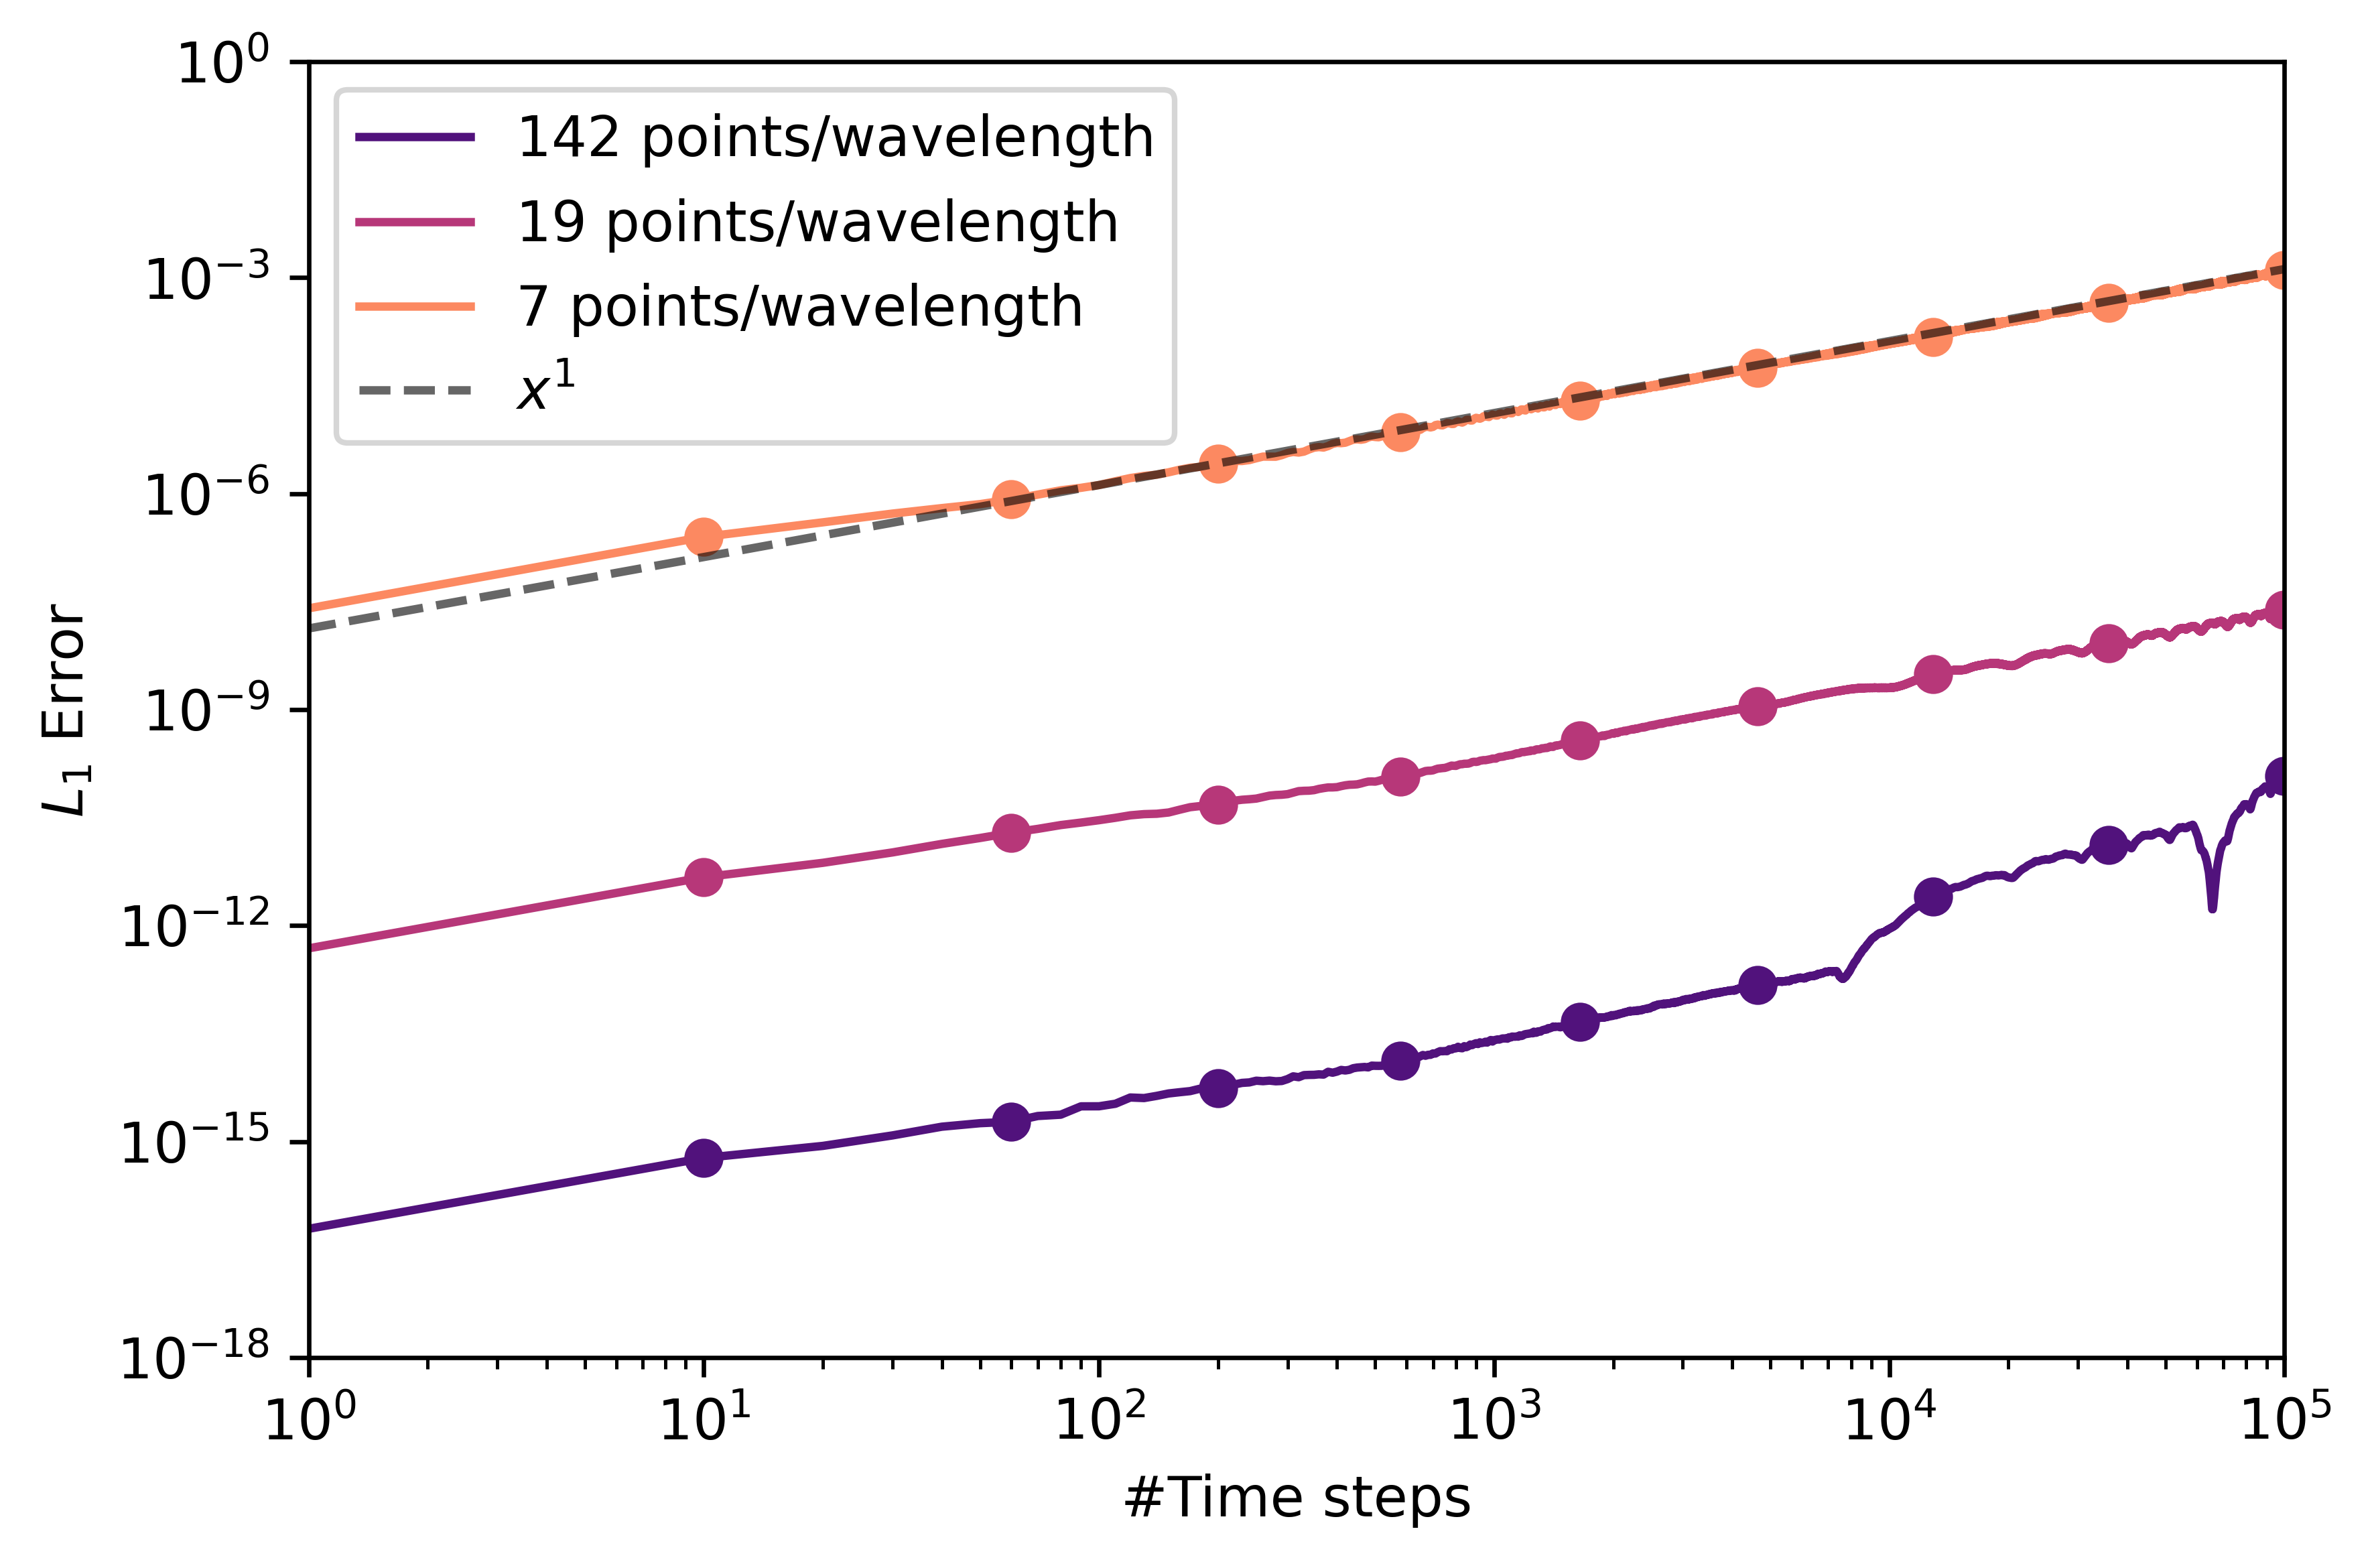

In [34]:
df = pd.read_csv("results/lt_stability_gaussian.csv")

set_cycle(5, start=1)

# Plotting
plt.figure(figsize=(6, 4), dpi=600)  # High-resolution plot

N_points = 64


#128 * min_wavelength / 0.077426, 128 * min_wavelength / 0.599484, 128 * min_wavelength / 1.66816
#142.0711388939116, 18.349113571004395, 6.594091693842317

source_map = {
    "GaussianWavePacketSlow": r"$142$ points/wavelength",
    #"GaussianWavePacketSlowFilter": r"$142$ points/wavelength w filter",
    "GaussianWavePacketMedium": r"$19$ points/wavelength",
    "GaussianWavePacketFast": r"$7$ points/wavelength",

}

# Assign labels based on 'RunName'
df['Label'] = df['Source'].map(source_map)


# Plot data for each label
for label, group_df in df.groupby('Label'):
    x = np.arange(len(group_df['Time']))*10
    y = 0.5 * (group_df['Error(Real)'] + group_df['Error(Imag)'])


    # Calculate logarithmically spaced indices based on the length of k, avoiding log10(0)
    indices = np.geomspace(1, len(x), num=10, dtype=int) - 1  # Subtract 1 to adjust for index starting at 0
    # Ensure unique indices if overlapping occurs due to rounding and bounds
    unique_indices = np.unique(indices)
    line, = plt.plot(x, y, label=f'{label}', linestyle='-')
    plt.plot(x[unique_indices], y.array[unique_indices], marker='o', linestyle='', c= line.get_color())

    if label == r'$7$ points/wavelength':
        y_ref = y.iloc[10] * (x/x[10])
        plt.plot(x, y_ref, 'k--', alpha = 0.6, label="$x^1$")

#plt.title('Real and Imaginary Part Errors as a Function of Wavelength')
plt.xlabel('#Time steps')
plt.ylabel('$L_1$ Error')
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, 1e5)
plt.ylim(1e-18, 1)
# Adding legend
plt.legend(loc="upper left")

# Show or save the plot
plt.tight_layout()
plt.savefig('plots/stability_gaussian.pdf')  # Save the plot as a PNG file
# plt.show()  # Uncomment to display the plot instead


# Performance test

         Time  Step        dt         NCell  NUpdate_Cell  ElapsedTime  \
0    0.000017     1  0.000017  1.070000e+09  1.070000e+09         2.10   
1    0.000034     2  0.000017  1.070000e+09  1.070000e+09         2.06   
2    0.000051     3  0.000017  1.070000e+09  1.070000e+09         2.10   
3    0.000068     4  0.000017  1.070000e+09  1.070000e+09         2.23   
4    0.000085     5  0.000017  1.070000e+09  1.070000e+09         2.11   
..        ...   ...       ...           ...           ...          ...   
195  0.000272    16  0.000017  1.070000e+09  1.070000e+09        26.90   
196  0.000289    17  0.000017  1.070000e+09  1.070000e+09        26.60   
197  0.000306    18  0.000017  1.070000e+09  1.070000e+09        26.60   
198  0.000323    19  0.000017  1.070000e+09  1.070000e+09        26.60   
199  0.000340    20  0.000017  1.070000e+09  1.070000e+09        26.80   

     Perf_Overall  Perf_PerRank  NUpdate_Lv0  NUpdate_Lv1  NUpdate_Lv2  \
0     512000000.0   128000000.0      

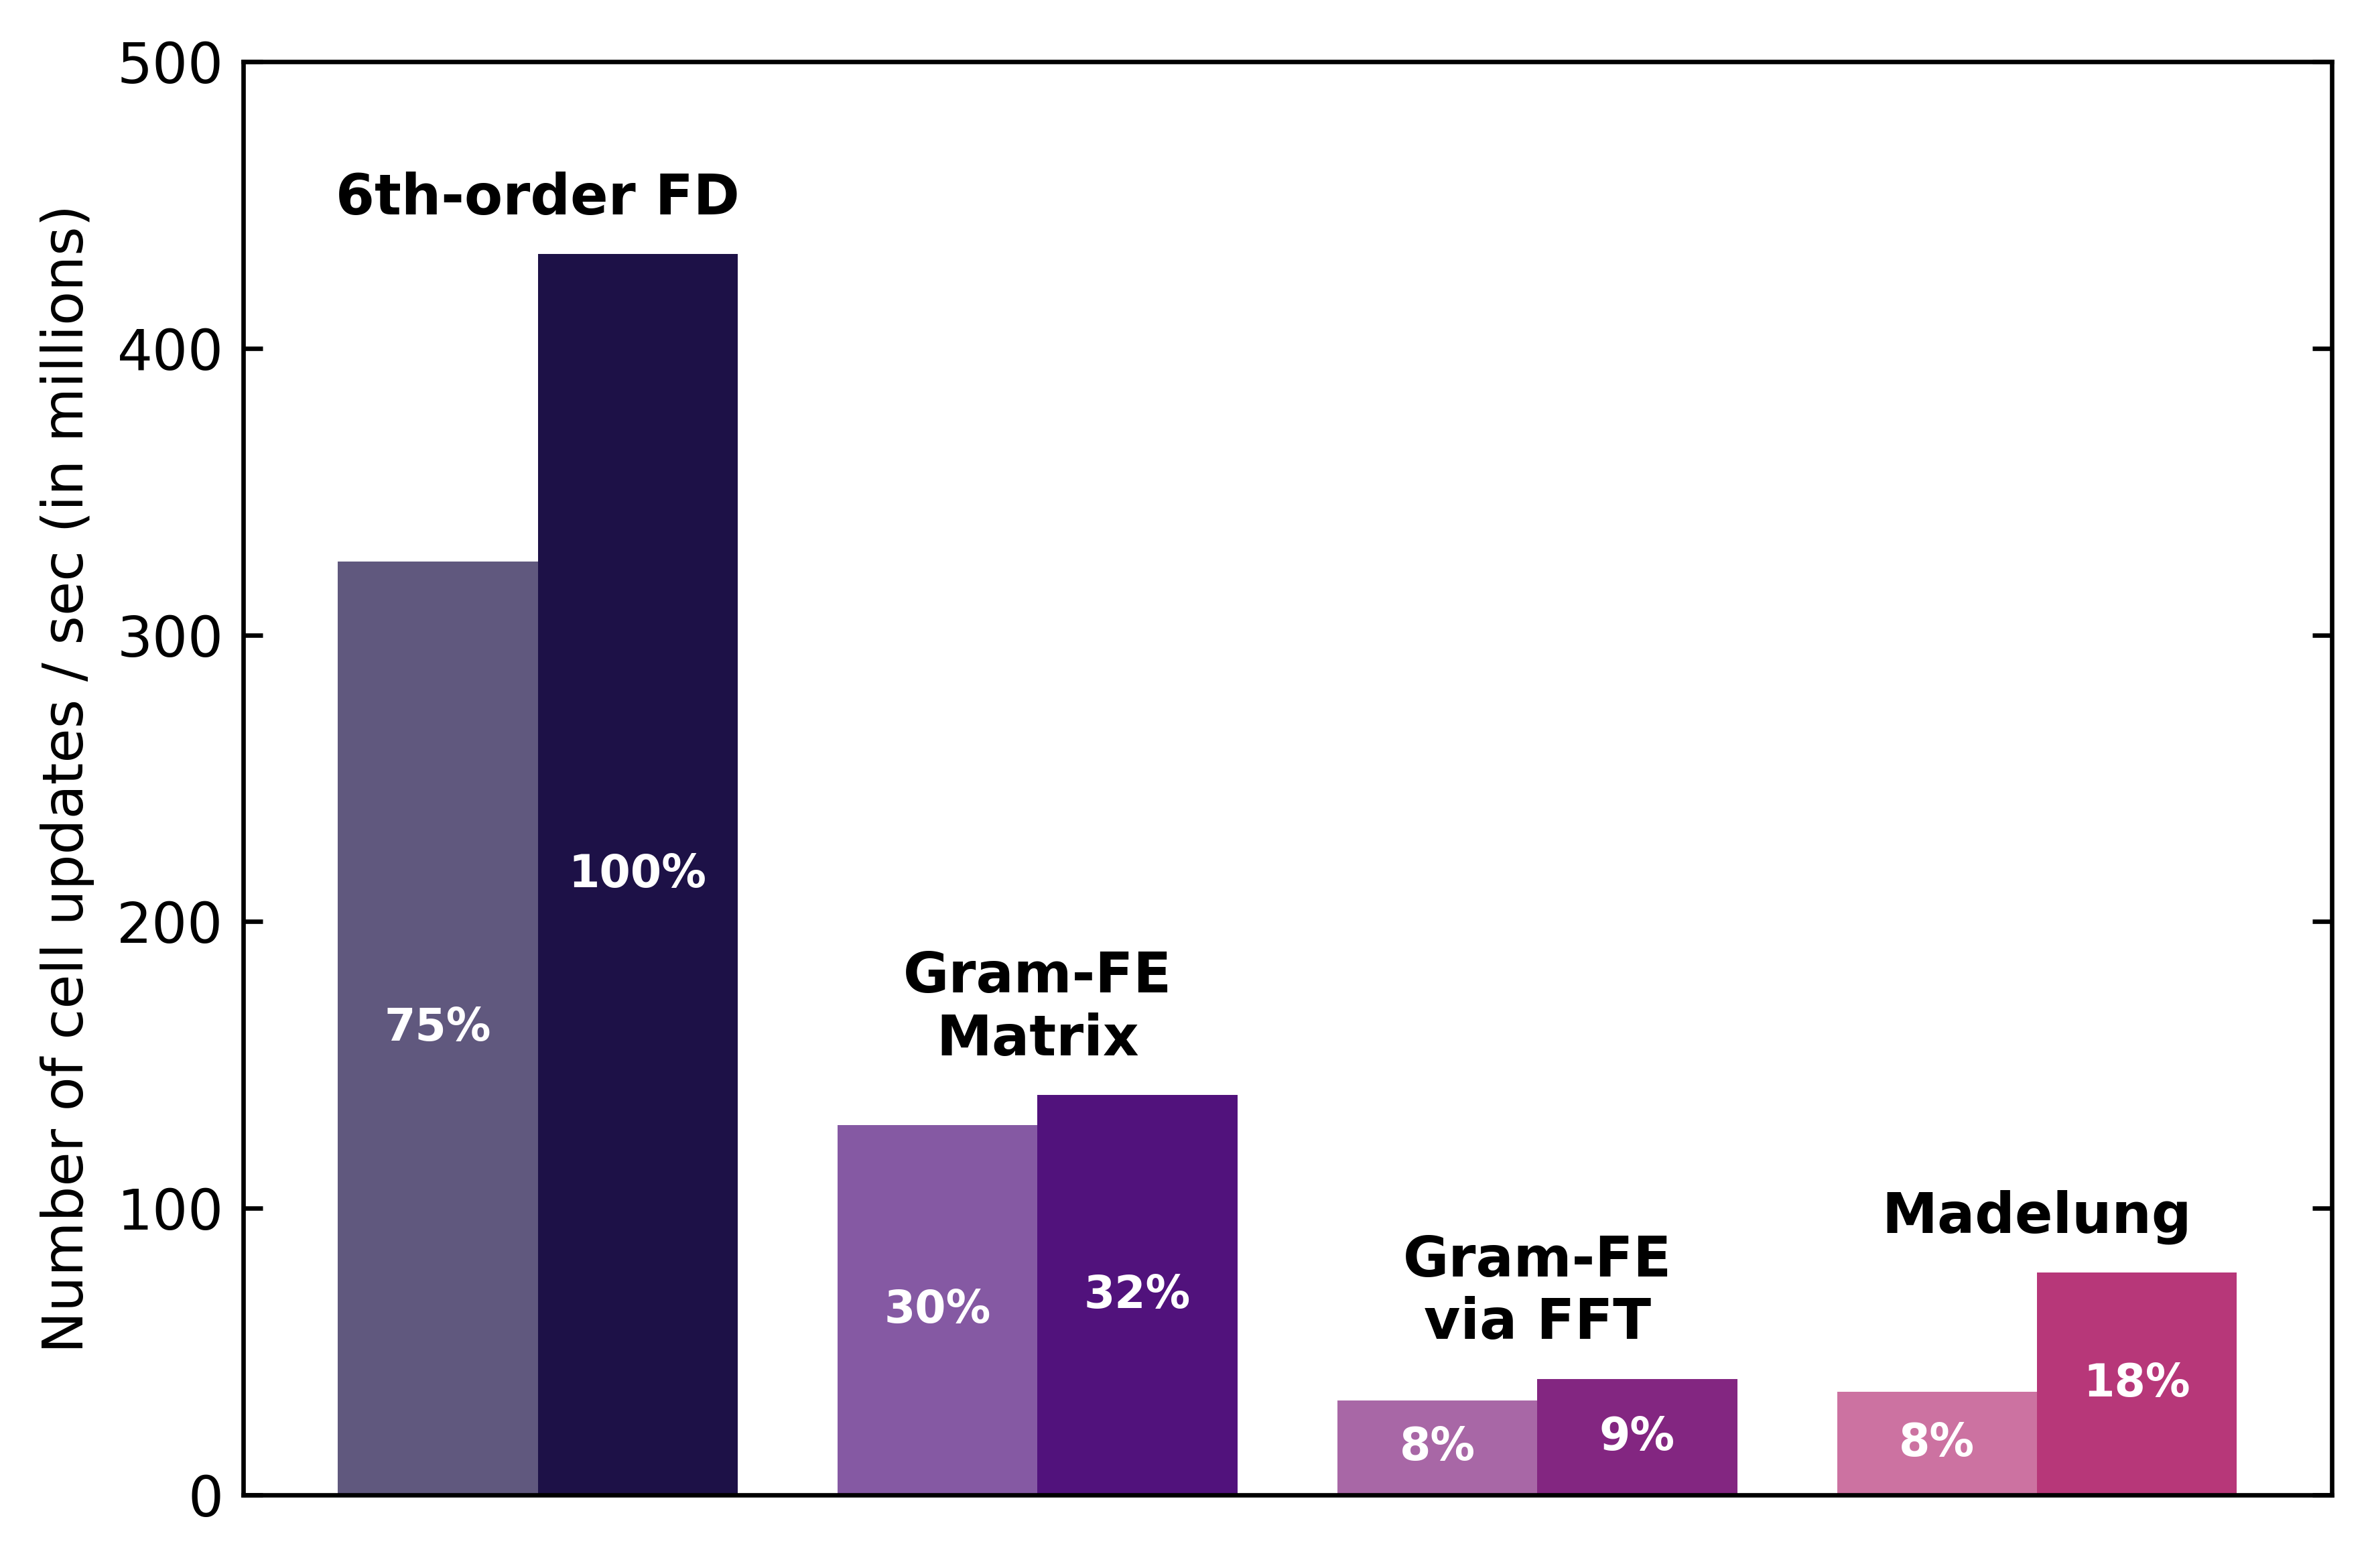

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined data from the CSV file
data_path = 'results/performance_test.csv' # Update this path
data = pd.read_csv(data_path)

set_cycle(9, 1)

# Define your folder to label mapping here
folder_to_label = {
    'gramfe_matmul_gpu': r'Gram-FE' + '\nMatrix - GPU',
    'gramfe_fft_gpu': r'Gram-FE' + '\nvia FFT - GPU',
    'fluid_gpu': 'Madelung - GPU',
    #'fd2_gpu': r'4th-order FD - GPU',
    'fd4_gpu': r'6th-order FD - GPU',
    'gramfe_matmul_cpu': r'Gram-FE' + '\nMatrix - CPU',
    'gramfe_fft_cpu': r'Gram-FE' + '\nvia FFT - CPU',
    'fluid_cpu': 'Madelung - CPU',
    #'fd2_cpu': r'4th-order FD - CPU',
    'fd4_cpu': r'6th-order FD - CPU',
}

# Map the folder names to labels
data['Label'] = data['FolderName'].map(folder_to_label)
print(data)
# Calculate the average Perf_PerRank for each label
average_perf_per_label = data.groupby('Label', as_index=False)['Perf_Overall'].mean()

print(average_perf_per_label)
# Normalize to the performance of the 6th order FD and convert to percent
fourth_order_FD_avg_perf = average_perf_per_label.loc[1]["Perf_Overall"]
normalized_perf          = average_perf_per_label.copy()
#normalized_perf["Perf_Overall"] = (average_perf_per_label["Perf_Overall"] / fourth_order_FD_avg_perf) * 100


# Set the plot size
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=600)  # High-resolution plot

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Generate the bar plot manually to control colors
bars = []

for i, (label, perf) in enumerate(zip(normalized_perf['Label'], normalized_perf['Perf_Overall'])):
    if i%2 == 0:
        x_shift = -0.3
        alpha = 0.7
    else:
        x_shift = 0.3
        alpha = 1.0
    x = int(i/2) * 1.5
    perf /= 1e6
    bar = ax1.bar(x  + x_shift, height= perf, width=0.6, color=colors[int(i/2) % len(colors)], alpha=alpha)    # Add text above the bar
    bars.append(bar)
    if i%2 == 1:
        ax1.text(x=x, y=perf + 10, s=label.rstrip("- GPU"),
                ha='center', va='bottom', weight='bold')


# Add text inside the bar
for bar_container in bars:
    for bar in bar_container:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height/2, f'{(height * 1e6 / fourth_order_FD_avg_perf) * 100:.0f}%',
                ha='center', va='center', color='white', weight='bold', fontsize=8)

ax1.set_xticks([])  # Hide x-ticks as before

# Configure primary y-axis
ax1.set_ylabel('Number of cell updates / sec (in millions)')
ax1.set_ylim(0, 500)

ax1.tick_params(axis='x', which='both', direction='in', top=True)  # Enable top ticks
ax1.tick_params(axis='y', which='both', direction='in', right=True)  # Enable right ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Parallel Scaling

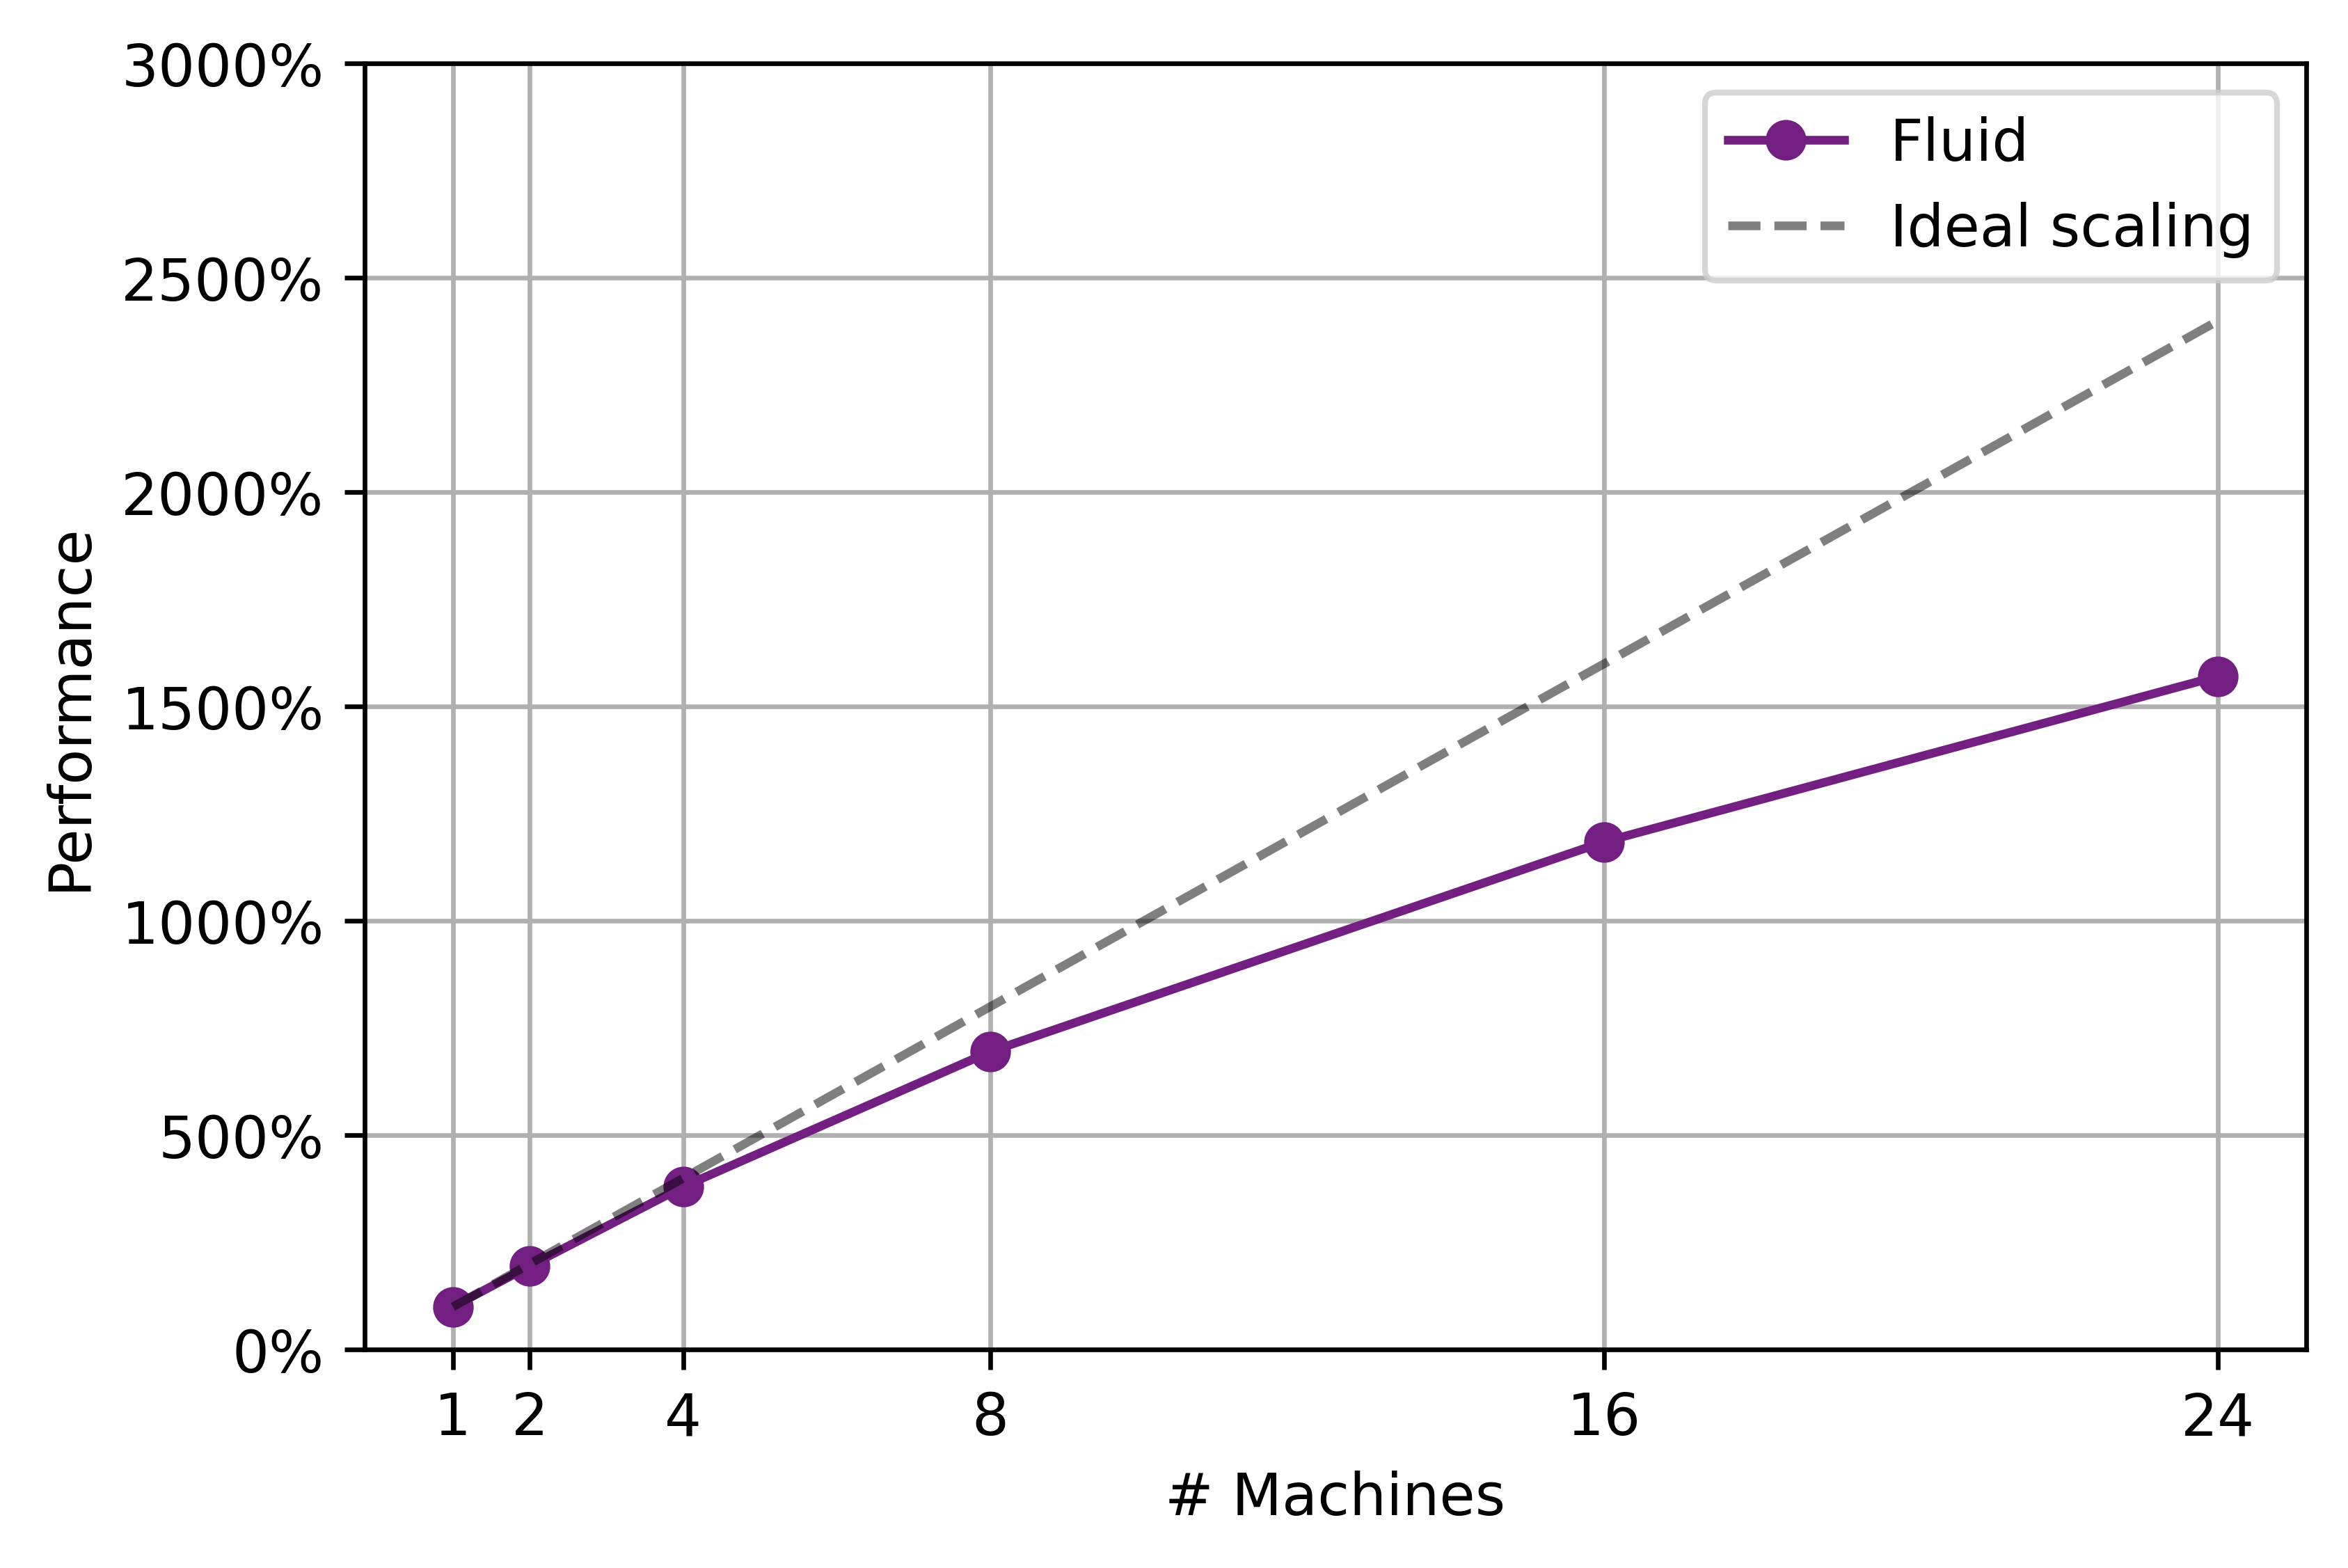

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined data
data_path = 'results/combined_scaling.csv'  # Update this path
data = pd.read_csv(data_path)

set_cycle(4, 1)
# Define your folder to label mapping here
folder_to_label = {
    #'VortexPairLinear': 'Wave-only',
    #'VortexPairLinear_Hybrid': 'Fluid',
    'Fluid': 'Fluid',
    #'Wave': 'Wave'
    # Add your mappings
}

# Map the folder names to labels
data['Label'] = data['Scheme'].map(folder_to_label)

# Calculate the average Perf_Overall for each FolderAttribute and Rank
df = data.groupby(['Label', 'Rank'])['Perf_Overall'].mean().reset_index()

# Step 1: Find the Perf_Overall value for "Wave-only" at Rank 1
baseline_value = df[(df['Label'] == 'Fluid') & (df['Rank'] == 1)]['Perf_Overall'].iloc[0]

# Step 2: Normalize all Perf_Overall values by this baseline
df['Normalized_Perf'] = df['Perf_Overall'] / baseline_value

# Step 3: Optionally, express as percentage
df['Normalized_Perf_Percent'] = df['Normalized_Perf'] * 100

# Set the plot size
plt.figure(figsize=(6, 4), dpi=600)  # High-resolution plot


# Plot the average Perf_Overall for each FolderAttribute
for folder_attr, group_data in df.groupby('Label'):
    plt.plot(group_data['Rank'], group_data['Normalized_Perf_Percent'], marker='o', linestyle='-', label=folder_attr)

x = np.arange(1, data['Rank'].max()+1)

plt.plot(x, 100*x, label = "Ideal scaling", c="k", ls="--", alpha =0.5)
plt.xlabel('# Machines')
plt.ylabel('Performance')
plt.ylim(0, 3000)

# Set y-axis labels with '%' suffix
current_yticks = plt.gca().get_yticks()
plt.yticks(current_yticks, [f'{y:.0f}%' for y in current_yticks])

plt.legend()
plt.xticks([1, 2, 4, 8, 16, 24])  # Assuming Rank is sequential and starts at 1
plt.grid(True)
plt.show()


# Interpolation

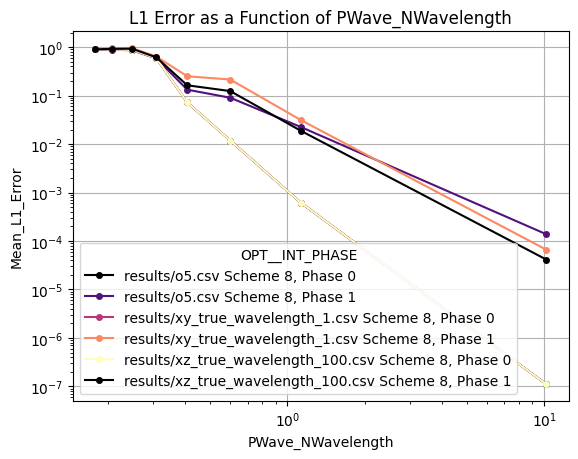

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

set_cycle(5)
fns = [#'results/interpolation_plane_wave.csv',
       #'results/interpolation_plane_wave_no_xy.csv',
       #'results/vpl_interpolation.csv',
       #'results/xy_1.csv',
       #'results/xy_10.csv',
       #'results/xy_100.csv',
       #'results/o5.csv',
       #'results/o8.csv',
       #'results/o14.csv',
       #'results/ipr.csv',
       #'results/xy_150.csv'
    #"results/ipr.csv",
    #"results/o8.csv",
    "results/o5.csv",
    #"results/o8.csv",
    #"results/xy_false_wavelength_1.csv",
    "results/xy_true_wavelength_1.csv",
    #"results/xy_true_wavelength_3.csv",
    #"results/xy_true_wavelength_5.csv",
    #"results/xy_true_wavelength_10.csv",
    "results/xz_true_wavelength_100.csv"
]

for fn in fns:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(fn)

    # Filter rows where OPT__FLU_INT_SCHEME equals OPT__REF_FLU_INT_SCHEME
    filtered_df = df[df['OPT__FLU_INT_SCHEME'] == df['OPT__REF_FLU_INT_SCHEME']]

    # Plot Mean_L1_Error as a function of PWave_NWavelength for different OPT__INT_PHASE options
    # Group by OPT__INT_PHASE to plot each option as a separate line
    for (scheme, phase), group_data in filtered_df.groupby(['OPT__FLU_INT_SCHEME', 'OPT__INT_PHASE']):
    #for (scheme, phase), group_data in filtered_df.groupby(['OPT__FLU_INT_SCHEME', 'OPT__INT_PHASE']):
        plt.plot(64 / group_data["VorPairLin_kx"] / (2*np.pi), group_data['Mean_L1_Error'], label=f'{fn} Scheme {scheme}, Phase {phase}', marker='o', linestyle='-', markersize=4)
        #plt.plot(64/group_data['PWave_NWavelength'], group_data['Mean_L1_Error'], label=f'{fn} Scheme {scheme}, Phase {phase}', marker='o', linestyle='-', markersize=4)
x = np.arange(1, 100).astype(float)
#plt.plot(x, 100000 * x**(-12))
plt.xlabel('PWave_NWavelength')
plt.ylabel('Mean_L1_Error')
plt.title('L1 Error as a Function of PWave_NWavelength')
plt.legend(title='OPT__INT_PHASE')
plt.yscale('log')  # Use logarithmic scale for better visibility of errors
plt.xscale('log')  # Use logarithmic scale for better visibility of errors
plt.grid(True)
plt.show()


# Power spectrum

In [84]:
redshifts     = np.array([100, 99, 90, 80, 70, 63, 50, 40, 31, 20, 15, 14, 13, 12, 11, 10, 9, 8, 7])
redshifts     = np.sort(redshifts)[::-1]
scale_factors = 1/(redshifts+1)

In [85]:
print("#Dump ID\tDump Time")
for i, a in enumerate(scale_factors):
    print(i, "\t", f"{a:2.16f}")
print("***************END LINE***************")

#Dump ID	Dump Time
0 	 0.0099009900990099
1 	 0.0100000000000000
2 	 0.0109890109890110
3 	 0.0123456790123457
4 	 0.0140845070422535
5 	 0.0156250000000000
6 	 0.0196078431372549
7 	 0.0243902439024390
8 	 0.0312500000000000
9 	 0.0476190476190476
10 	 0.0625000000000000
11 	 0.0666666666666667
12 	 0.0714285714285714
13 	 0.0769230769230769
14 	 0.0833333333333333
15 	 0.0909090909090909
16 	 0.1000000000000000
17 	 0.1111111111111111
18 	 0.1250000000000000
***************END LINE***************


/tmp/ipykernel_23888/3853995620.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


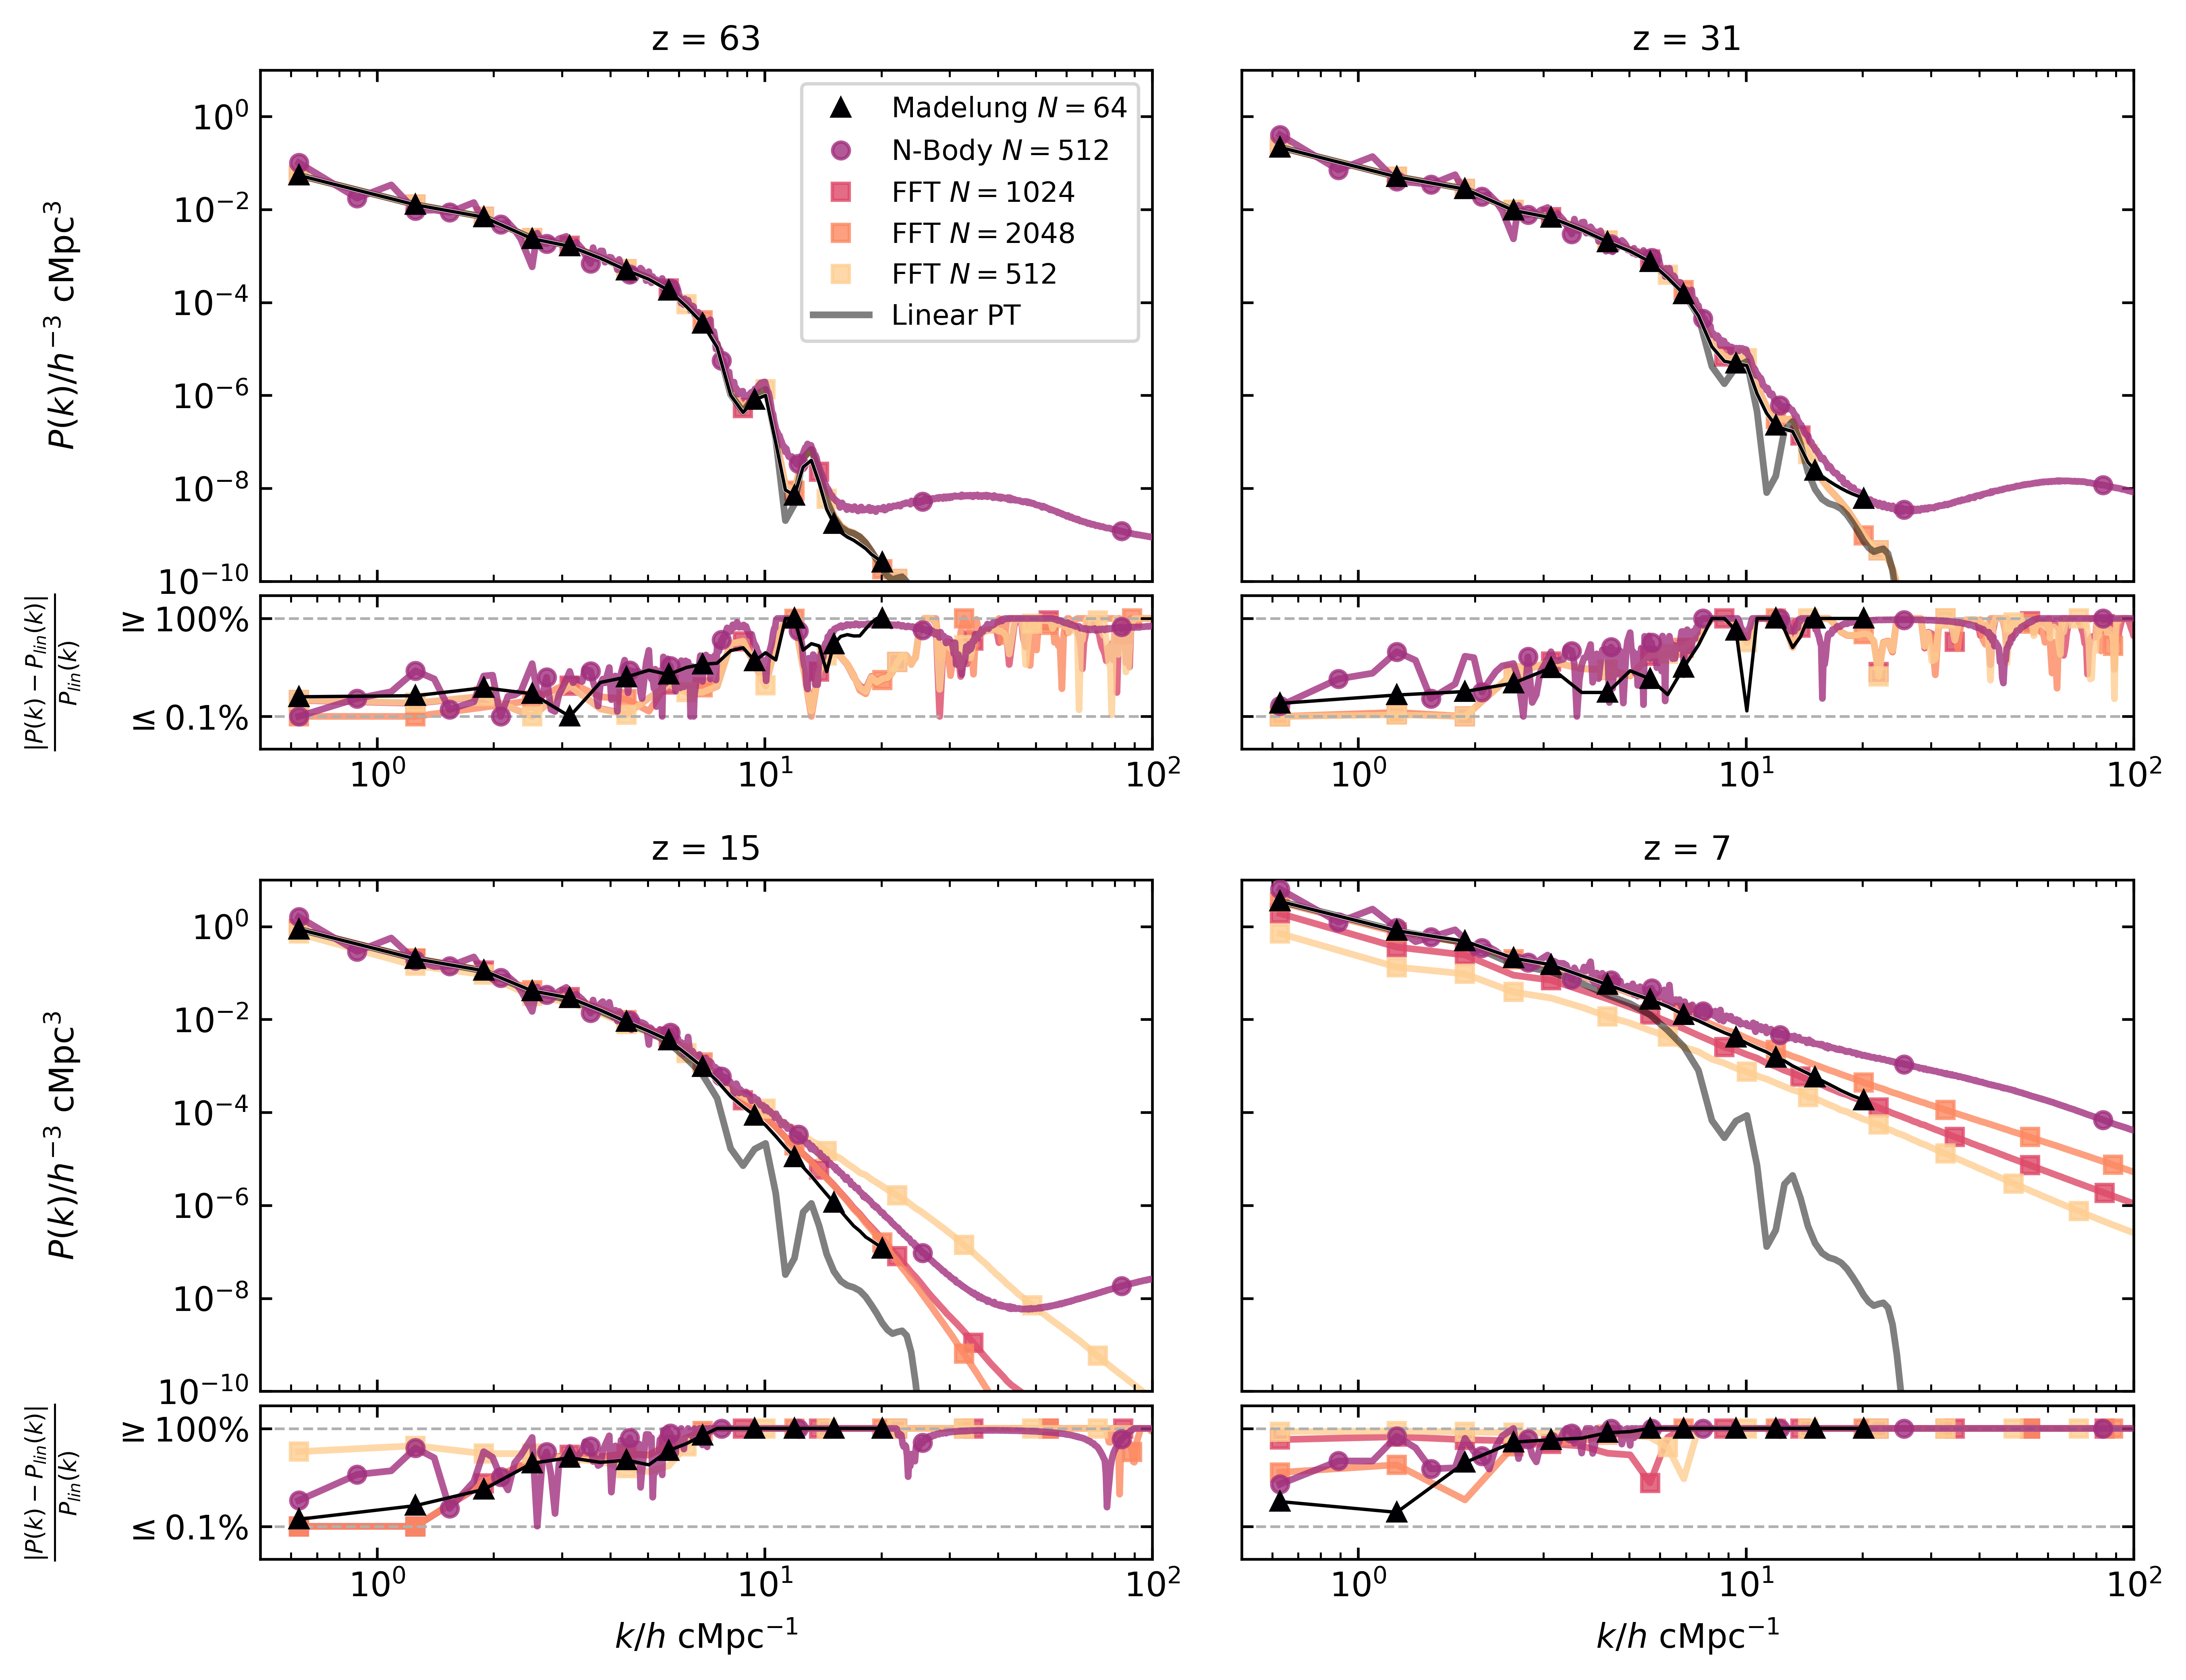

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy
# Read the DataFrame from disk

input_file = "results/fdm_spectra.csv"
fdm_df = pd.read_csv(input_file)
input_file = "results/cdm_spectra.csv"
cdm_df = pd.read_csv(input_file)
combined_df = pd.concat([fdm_df, cdm_df], ignore_index=True)

# Set the color cycle to 'magma'
num_colors = 11
colors = plt.cm.magma([0, 0.45, 0.6, 0.75, 0.9])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# Find the unique Spec IDs in the DataFrame
spec_ids = combined_df['Spec ID'].unique()

# Filter out the reference spectrum (Spec ID 0)
a_ref  = scale_factors[0]

# Set up figure with custom layout
fig = plt.figure(figsize=(10, 8), dpi=600)

# Create a GridSpec with 8 rows (for 4 pairs of k-P and error plots) and 2 columns
gs = gridspec.GridSpec(5, 2, height_ratios=[2, 0.6, 0.4, 2, 0.6], hspace=0.0, wspace=0.1)

legend_added = False

# Define marker and marker size mappings for different methods
marker_dict = {
    'nbody': 'o',  # Example method names
    'gramfe': 's',
    'finite_difference': '^',
    'fluid': '^',
    'spectral': 's',
}
size_dict = {
    'nbody': 5,
    'gramfe': 5,
    'finite_difference': 5,
    'fluid': 5,
    'spectral': 5,
}

lw_dict = {
    'nbody': 2,
    'gramfe': 2,
    'finite_difference': 3,
    'fluid': 1,
    'spectral': 2,
}
alpha_dict = {
    'nbody': 0.8,
    'gramfe': 2,
    'finite_difference': 3,
    'fluid': 1,
    'spectral': 0.8,
}
method_name_dict = {
    'finite_difference': 'Finite Difference',
    'fluid': 'Madelung',
    'gramfe': 'Gram-Fourier extension',
    'nbody': 'N-Body',
    'spectral': 'FFT',
}
zorder_dict = {
    'finite_difference': 'Finite Difference',
    'fluid': 10,
    'gramfe': 'Gram-Fourier extension',
    'nbody': 5,
    'spectral': 0,
}

# Function to format resolution label
def format_resolution_label(resolution):
    # Extracts number from resolution string (e.g., 'n_128') and formats it
    number = resolution.split('_')[1]
    return f"$N = {number}$"


for i, spec_id in enumerate([5, 8, 10, 18]):
    a = scale_factors[spec_id]
    row = int(i / 2)
    col = (i % 2 != 0)
    ax1 = fig.add_subplot(gs[row + 2 * row, col])  # k-P plot for this pair
    ax2 = fig.add_subplot(gs[row + 2 * row + 1, col], sharex=ax1)  # Error plot directly below ax1

    # Remove x-tick labels for ax1, since ax2 will share the x-axis
    plt.setp(ax1.get_xticklabels(), visible=False)


    for (method, resolution), group_df in combined_df.groupby(['Method', 'Resolution']):
        df = group_df[group_df['Spec ID'] == spec_id]
        df_ref = group_df[group_df['Spec ID'] == 0]

        if df.empty or df_ref.empty:
            continue

        if method == "finite_difference":
            continue
        if method == "gramfe":# and not resolution == "n_2048":
            continue
        if method == "fluid" and not resolution == "n_64":
            continue
        if method == "spectral" and not (resolution == "n_512" or resolution == "n_2048" or resolution =="n_1024"):
            continue
        if method == "nbody" and not resolution == "n_512":
            continue

        k = df["k"].values
        P = df["Power"].values
        P_ref = (a / a_ref) ** 2 * df_ref['Power'].values

        # Apply method name mapping
        method_label = method_name_dict.get(method, method)  # Default to raw method name if not found
        # Format resolution label
        resolution_label = format_resolution_label(resolution)

        label = f"{method_label} {resolution_label}"

        # Select marker and size based on the method
        marker = marker_dict.get(method, 'o')  # Default to 'o' if method not in dict
        size = size_dict.get(method, 4)  # Default to 4 if method not in dict
        lw = lw_dict.get(method, 4)  # Default to 4 if method not in dict
        alpha = alpha_dict.get(method, 4)  # Default to 4 if method not in dict
        zorder = zorder_dict.get(method, 4)  # Default to 4 if method not in dict


        # Calculate logarithmically spaced indices based on the length of k, avoiding log10(0)
        indices = np.geomspace(1, len(k), num=15, dtype=int) - 1  # Subtract 1 to adjust for index starting at 0

        # Ensure unique indices if overlapping occurs due to rounding
        unique_log_indices = np.unique(indices)

        if method == "fluid":
            ax1.plot(k, P, linestyle='-', lw = lw + 0.3, c = "white", alpha=alpha, zorder=zorder)
        # Plot the entire dataset with lines
        line, = ax1.plot(k, P, linestyle='-', lw = lw, alpha=alpha, zorder=zorder)
        # Overlay markers only on the subset of points
        ax1.plot(k[unique_log_indices], P[unique_log_indices], label=label, linestyle='', marker=marker, markersize=size, alpha=alpha, c=line.get_color(), zorder=zorder)

        #ax1.plot(k, P, label=label, linestyle='--', marker='o', markersize=4, alpha=0.7) #linestyle='--', marker=marker, markersize=size, )
        if method == "spectral" and resolution == "n_512":
            ax1.plot(k, P_ref, c="k", alpha=0.5, lw =2, label="Linear PT")

        error = np.abs(P - P_ref) / P_ref
        error[error>1] = 1
        error[error<1e-3] = 1e-3

        # Plot the entire dataset with lines
        ax2.plot(k, error, linestyle='-', alpha=alpha, lw = lw, c=line.get_color(), zorder=zorder)
        # Overlay markers only on the subset of points
        ax2.plot(k[unique_log_indices], error[unique_log_indices], linestyle='', marker=marker, markersize=size, alpha=alpha, c=line.get_color(), zorder=zorder)

    if not legend_added:
        ax1.legend(loc='upper right', fontsize='small', ncol=1)
        legend_added = True

    ax1.set_title(f'z = {redshifts[spec_id]}', fontsize=10)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_ylim(1e-10, 1e1)  # Adjust as needed
    ax1.set_xlim(0.5, 100)  # Adjust as needed
    #ax1.grid(True, which="both", ls="--")
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-4, 5)  # Adjust as needed
    ax2.grid(True, which="both", axis="y", ls="--")

    # Set ticks direction to inwards
    #ax.tick_params(axis='both',          # Apply changes to both x and y axes
    #            which='both',         # Apply changes to both major and minor ticks
    #            direction='in',       # Set direction of ticks to 'inwards'
    #            length=6,             # Length of the ticks
    #            width=1)              # Width of the ticks
    # Enable ticks on the top and right axes
    ax1.tick_params(axis='x', which='both', direction='in', top=True)  # Enable top ticks
    ax1.tick_params(axis='y', which='both', direction='in', right=True)  # Enable right ticks
    ax2.tick_params(axis='x', which='both', direction='in', top=True)  # Enable top ticks
    ax2.tick_params(axis='y', which='both', direction='in', right=True)  # Enable right ticks


    if row == 1:  # Only set xlabel for the last row of error plots
        ax2.set_xlabel(r'$k/h$ cMpc$^{-1}$')

    if col == 0:
        ax1.set_ylabel(r'$P(k) / h^{-3}$ cMpc$^3$',labelpad=20)
        ax2.set_ylabel(r'$\frac{|P(k) - P_{lin}(k)|}{P_{lin}(k)}$', labelpad=20)
        # Adjust y-axis label position
        ax1.yaxis.set_label_coords(-0.2, 0.5)
        ax2.yaxis.set_label_coords(-0.2, 0.5)

        # Set the locations for the y-ticks
        ax2.set_yticks([1e-3, 1])

        # Set the labels for the y-ticks
        ax2.set_yticklabels([r"$\leq 0.1\%$", r"$\geq 100\%$"])
    if col == 1:  # Remove y-ticks and labels for the second column
        ax1.set_yticklabels([])
        #ax1.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_yticks([1e-3, 1])
        #ax2.set_yticks([])
        #ax1.grid(True, which='both', linestyle='--')
        # Disable y-tick labels but leave the ticks (set them to invisible or zero length)
        #ax2.tick_params(axis='y', which='both', length=0, labelleft=False)  # This hides tick marks and labels

        ax2.grid(True, which='both', axis="y", linestyle='--')


# Remove padding between k-P and error plots while keeping padding between sets
gs.update(hspace=0.05)  # Adjust space between the k-P/error plot groups

plt.tight_layout()
plt.show()


## Compute softening length

In [22]:
# Calculation in Python
box_size_mpc = 2.8  # Size of the comoving box in Mpc/h
n_particles = 512**3  # Number of particles

# Mean inter-particle separation
l = (box_size_mpc ** 3 / n_particles) ** (1/3)

# Typical gravitational softening length range (1/20 to 1/40 of l)
epsilon_min = l / 40
epsilon_max = l / 20

l, epsilon_min, epsilon_max

(0.005468750000000001, 0.00013671875000000004, 0.0002734375000000001)

In [264]:
pip install yt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 2D Power Spectra

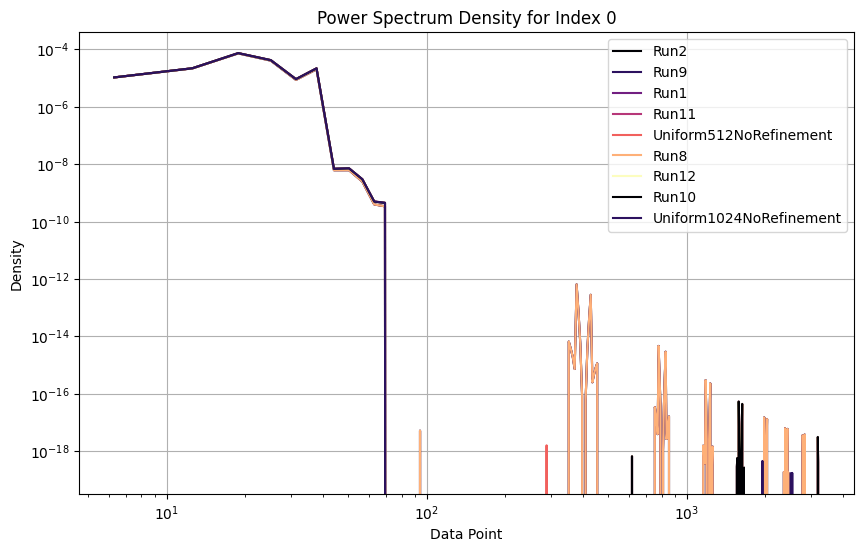

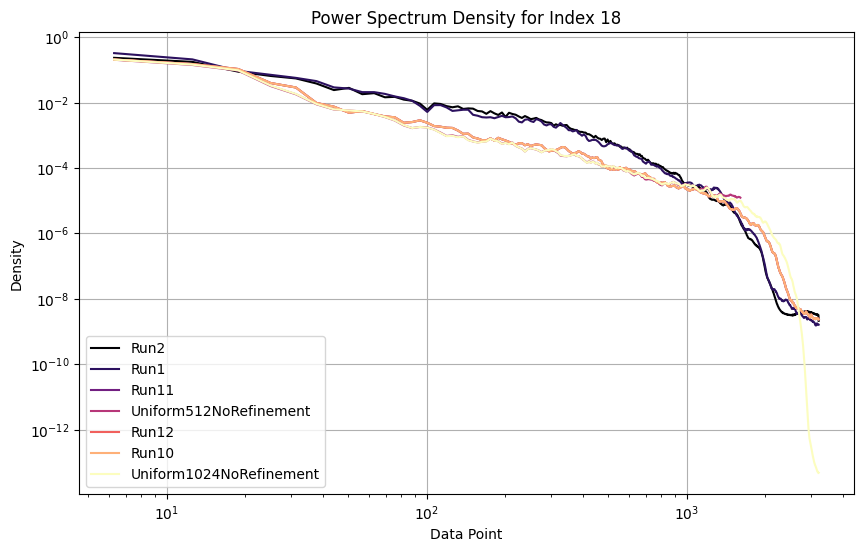

In [159]:
import os
import matplotlib.pyplot as plt

set_cycle(7)
def read_and_plot_data(base_folder, indices):
    # List all subfolders in the base folder
    subfolders = [os.path.join(base_folder, f) for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    # Loop through each index you are interested in
    for index in indices:
        plt.figure(figsize=(10, 6))  # Create a new figure for each index

        # Loop through each subfolder
        for subfolder in subfolders:
            # Construct the filename pattern to search for
            exclude = ["Run1", "Run2", "Run3","Run4"]
            if "Run5" in subfolder or "Run3" in subfolder or "Run4" in subfolder:
                continue
            if "Run6" in subfolder or "Run7" in subfolder or "Run3" in subfolder or "Run4" in subfolder:
                continue


            file_patterns = [
                f"power_spectrum_Density_{index:06d}_lv_04_1024_ndim_2.txt",
                f"power_spectrum_Density_{index:06d}_lv_00_512_ndim_2.txt",
                f"power_spectrum_Density_{index:06d}_lv_00_1024_ndim_2.txt",
                f"power_spectrum_Density_{index:06d}_lv_02_1024_ndim_2.txt"
            ]

            for file_pattern in file_patterns:
                file_path = os.path.join(subfolder, file_pattern)

                # Check if file exists and read data
                if os.path.exists(file_path):
                    with open(file_path, 'r') as file:
                        data = [float(line.strip()) for line in file if line.strip()]

                    N = int(len(data)/2)


                    # Plot the data
                    plt.loglog(data[:N], data[N:], label=f'{os.path.basename(subfolder)}')

        # Configure plot settings
        plt.title(f'Power Spectrum Density for Index {index}')
        plt.xlabel('Data Point')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()

# Usage example:
base_folder = '/home/xerox/Documents/Paper/A hybrid scheme combining fluid and wave solvers/hybrid_scheme_paper/hybrid_scheme_paper/2d_power'
indices = [0, 18]  # Add the indices you want to plot data for
read_and_plot_data(base_folder, indices)
